In [86]:
import os
import json
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import redirect_stdout, redirect_stderr

os.chdir("/home/tmoins/Documents/computational philology/SuperStyl")

from superstyl.load import load_corpus
from superstyl.svm import train_svm, plot_rolling
from superstyl.preproc.pipe import docs_to_samples, get_samples
from superstyl.load_from_config import load_corpus_from_config

# Directory for experiments
directory = "../chrestien/"
os.makedirs(directory, exist_ok=True)


# Experiment configuration

### Configuration with only function words

Finding the best culling value

In [87]:
# Base configuration
base_config = {
    "paths": "../data/xml/nowordnoelisions/train/*",
    "format": "tei",
    "sampling": {
        "enabled": True,
        "units": "verses",
        "sample_size": 375
    },
    "features": [
        {
            "type": "words",
            "n": 1,
            "k": 1000,
            "culling": 0,  # Will be modified in the loop
            "feat_list": "../data/function_words_old-french_of3c.json",
            "freq_type": "relative"
        }
    ]
}

culling_range = list(range(0, 100, 5))
f1_list = []
best_culling = 0
best_f1 = 0
verbose = False

# Iteration over culling values
for culling_value in culling_range:
    if verbose:
        print(f"\nTest with culling = {culling_value}:")
    
    # Configuration update
    config_dict = base_config.copy()
    config_dict["features"][0]["culling"] = culling_value
    
    # Configuration save
    config_file = os.path.join(directory, f'first_config.json')
    with open(config_file, 'w') as f:
        json.dump(config_dict, f, ensure_ascii=False, indent=4)
    
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull), redirect_stderr(devnull):
            # Corpus loading
            train_set, feat_list = load_corpus_from_config(config_file)
            
            # Model training
            results = train_svm(
                train=train_set,
                test=None,
                cross_validate="group-k-fold",
                balance="downsampling",
                class_weights=True,
                get_coefs=False
            )
    
    results_list = results['classification_report'].split()
    acc_idx = results_list.index('accuracy') + 1
    f1_result = float(results_list[acc_idx])
    f1_list.append(f1_result)
    
    if verbose:
        print(f" F1-score: {f1_result}")
    
    if f1_result > best_f1:
        best_f1 = f1_result
        best_culling = culling_value

# Best configuration save
config_dict["features"][0]["culling"] = best_culling
config_file = os.path.join(directory, f'FW_culling_{best_culling}.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print("Done!")

Done!



Best culling value: 10
Best F1-score: 0.86
Best configuration saved as: ../chrestien/FW_culling_10.json


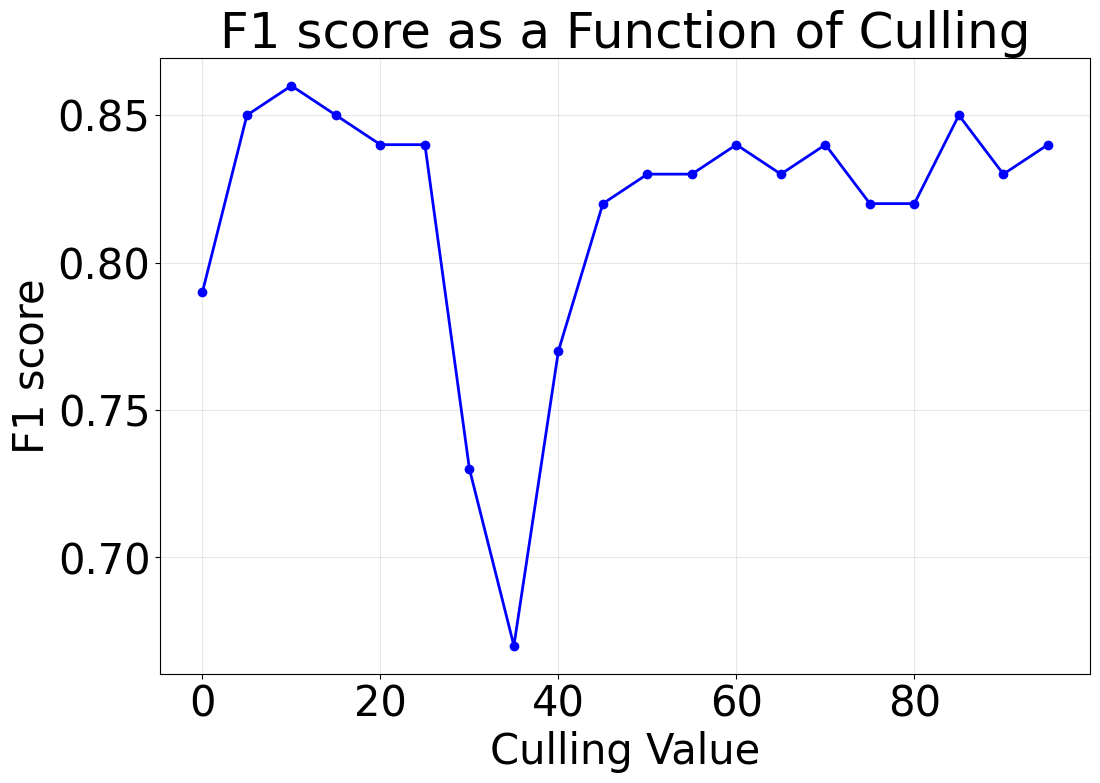

In [88]:

config_file = os.path.join(directory, 'FW_culling_10.json')

with open(config_file, 'r') as f:
   config_dict = json.load(f)

# Results visualization
plt.figure(figsize=(12, 8))

# Main plot: Precision vs Culling
culling_range = list(range(0, 100, 5))
plt.plot(culling_range, f1_list, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Culling Value')
plt.ylabel('F1 score')
plt.title('F1 score as a Function of Culling')
plt.grid(True, alpha=0.3)

print(f"\nBest culling value: {best_culling}")
print(f"Best F1-score: {best_f1}")
print(f"Best configuration saved as: {config_file}")

plt.show()

### Configuration with on metrics (syllable scale)

Finding the best combination of culling + n-gram value


Best combo: (60, 11)
Best F1-score: 0.88
Best configuration saved as: ../chrestien/MetSyll_n_11_culling_60.json


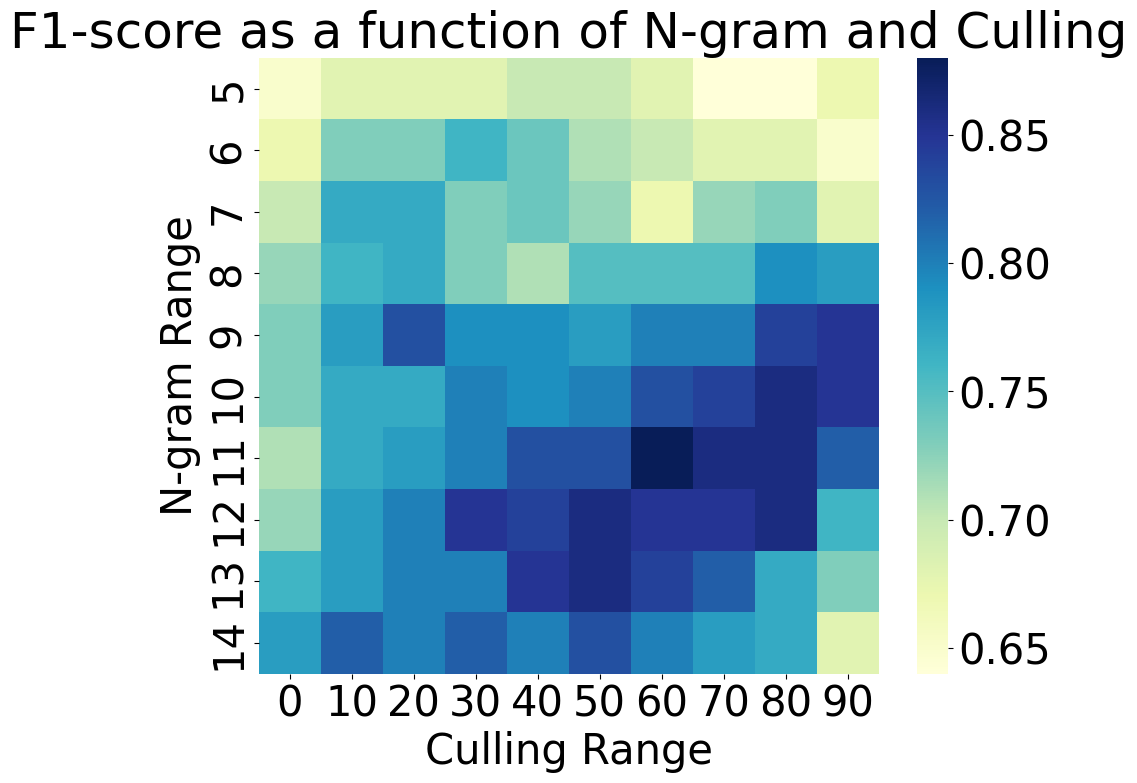

In [89]:
# Base configuration
base_config = {
    "paths": "../data/xml/nowordnoelisions/train/*",
    "format": "tei",
    "sampling": {
        "enabled": True,
        "units": "verses",
        "sample_size": 375
    },
    "features": [
    {
        "type": "met_syll",
        "n": 5, # will be modified in the loop
        "culling": 0 # will be modified in the loop
    },
    ]
}


culling_range = list(range(0, 100, 10))
n_range = list(range(5,15))

best_combo = (0, 5)

f1_list = np.zeros((len(n_range), len(culling_range)))
best_f1 = 0

verbose = False

for (i, n) in enumerate(n_range):
    # Iteration over culling values
    for (j, culling_value) in enumerate(culling_range):
        if verbose:
            print(f"n = {n}, with culling = {culling_value}%:")
        
        # Configuration update
        config_dict = base_config.copy()
        config_dict["features"][0]["culling"] = culling_value
        config_dict["features"][0]["n"] = n
        
        # Configuration save
        config_file = os.path.join(directory, f'first_config.json')
        with open(config_file, 'w') as f:
            json.dump(config_dict, f, ensure_ascii=False, indent=4)
        
        with open(os.devnull, 'w') as devnull:
            with redirect_stdout(devnull), redirect_stderr(devnull):
                # Corpus loading
                train_set, feat_list = load_corpus_from_config(config_file)
                
                # Model training
                results = train_svm(
                    train=train_set,
                    test=None,
                    cross_validate="group-k-fold",
                    balance="downsampling",
                    class_weights=True,
                    get_coefs=False
                )
        
        results_list = results['classification_report'].split()
        acc_idx = results_list.index('accuracy') + 1
        f1_result = float(results_list[acc_idx])
        f1_list[i, j] = f1_result
        
        if verbose:
            print(f" F1-score: {f1_result}")
        
        if f1_result > best_f1:
            best_f1 = f1_result
            best_combo = (culling_value, n)



fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(f1_list, annot=False, fmt=".3f", cmap="YlGnBu",
                     xticklabels=culling_range, yticklabels=n_range)

plt.xlabel('Culling Range')
plt.ylabel('N-gram Range')
plt.title('F1-score as a function of N-gram and Culling')


# Best configuration save
config_dict["features"][0]["culling"] = best_combo[0]
config_dict["features"][0]["n"] = best_combo[1]
config_file = os.path.join(directory, f'MetSyll_n_{best_combo[1]}_culling_{best_combo[0]}.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print(f"\nBest combo: {best_combo}")
print(f"Best F1-score: {best_f1}")
print(f"Best configuration saved as: {config_file}")

plt.show()

### Configuration with on metrics (line scale)

Finding the best combination of culling


Best culling value: 30
Best F1-score: 0.75
Best configuration saved as: ../chrestien/MetLine_n_2_culling_30.json


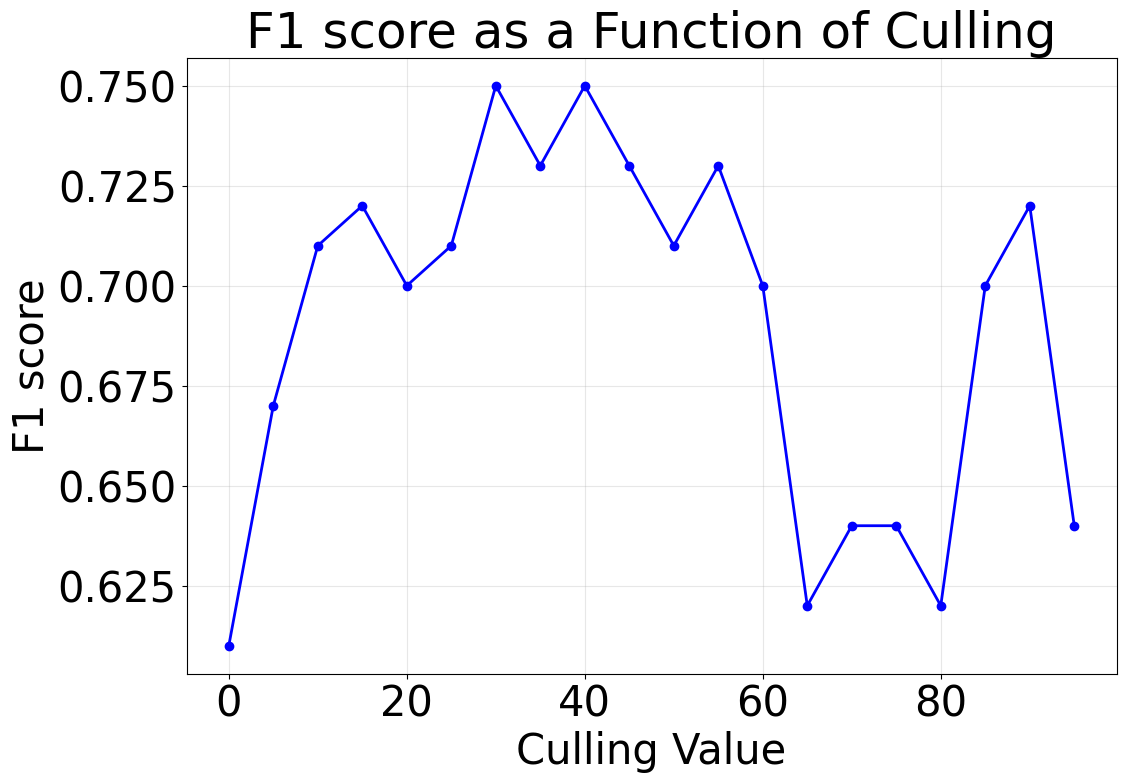

In [90]:
# Base configuration
base_config = {
    "paths": "../data/xml/nowordnoelisions/train/*",
    "format": "tei",
    "sampling": {
        "enabled": True,
        "units": "verses",
        "sample_size": 375
    },
    "features": [
    {
        "type": "met_line",
        "n": 1,
        "culling": 0 # will be modified in the loop
    },
    ]
}

culling_range = list(range(0, 100, 5))
f1_list = []
best_culling = 0
best_f1 = 0
verbose = False

# Iteration over culling values
for culling_value in culling_range:
    if verbose:
        print(f"\nTest with culling = {culling_value}:")
    
    # Configuration update
    config_dict = base_config.copy()
    config_dict["features"][0]["culling"] = culling_value
    
    # Configuration save
    config_file = os.path.join(directory, f'first_config.json')
    with open(config_file, 'w') as f:
        json.dump(config_dict, f, ensure_ascii=False, indent=4)
    
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull), redirect_stderr(devnull):
            # Corpus loading
            train_set, feat_list = load_corpus_from_config(config_file)
            
            # Model training
            results = train_svm(
                train=train_set,
                test=None,
                cross_validate="group-k-fold",
                balance="downsampling",
                class_weights=True,
                get_coefs=False
            )
    
    results_list = results['classification_report'].split()
    acc_idx = results_list.index('accuracy') + 1
    f1_result = float(results_list[acc_idx])
    f1_list.append(f1_result)
    
    if verbose:
        print(f" F1-score: {f1_result}")
    
    if f1_result > best_f1:
        best_f1 = f1_result
        best_culling = culling_value

# Results visualization
plt.figure(figsize=(12, 8))

# Main plot: Precision vs Culling
plt.plot(culling_range, f1_list, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Culling Value')
plt.ylabel('F1 score')
plt.title('F1 score as a Function of Culling')
plt.grid(True, alpha=0.3)

# Best configuration save
config_dict["features"][0]["culling"] = best_culling
config_file = os.path.join(directory, f'MetLine_n_2_culling_{best_culling}.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print(f"\nBest culling value: {best_culling}")
print(f"Best F1-score: {best_f1}")
print(f"Best configuration saved as: {config_file}")

plt.show()

### Configuration with function words + metrics (syllable scale)

Finding the best culling value + n value for both feature type

In [91]:
# Base configuration
base_config = {
    "paths": "../data/xml/nowordnoelisions/train/*",
    "format": "tei",
    "sampling": {
        "enabled": True,
        "units": "verses",
        "sample_size": 375
    },
    "features": [
    {
      "type": "met_syll",
      "n": 8, # is changing
      "culling": 0 # is changing
    },
    {
      "type": "words",
      "n": 1,
      "k": 1000,
      "culling": 0, # is_changing
      "feat_list": "../data/function_words_old-french_of3c.json",
      "freq_type": "relative"
    }
    ]
}


culling_range_met = list(range(0, 100, 10))
culling_range_w = list(range(0, 100, 10))
n_range = list(range(9,15))

top3_combo = [[5, 0, 0], [5, 0, 0], [5, 0, 0]]
top3_f1 = [0,0,0]

verbose = False

for n in n_range:
    for c_met in culling_range_met:
        # Iteration over culling values
        for c_w in culling_range_w:
            
            # Configuration update
            config_dict = base_config.copy()
            config_dict["features"][0]["culling"] = c_met
            config_dict["features"][1]["culling"] = c_w
            config_dict["features"][0]["n"] = n
            
            # Configuration save
            config_file = os.path.join(directory, f'first_config.json')
            with open(config_file, 'w') as f:
                json.dump(config_dict, f, ensure_ascii=False, indent=4)
            
            with open(os.devnull, 'w') as devnull:
                with redirect_stdout(devnull), redirect_stderr(devnull):
                    # Corpus loading
                    train_set, feat_list = load_corpus_from_config(config_file)
                    
                    # Model training
                    results = train_svm(
                        train=train_set,
                        test=None,
                        cross_validate="group-k-fold",
                        balance="downsampling",
                        class_weights=True,
                        get_coefs=False
                    )
            
            results_list = results['classification_report'].split()
            acc_idx = results_list.index('accuracy') + 1
            f1_result = float(results_list[acc_idx])
            
            if verbose:
                print(f" F1-score: {f1_result}")
            
            if f1_result > top3_f1[2]:
                if f1_result > top3_f1[1]:
                    if f1_result > top3_f1[0]:
                        top3_f1[0] = f1_result
                        top3_combo[0] = (n, c_met, c_w)
                        print(f"Current best combo: n = {n}, cull_met = {c_met}%, cull_fw = {c_w}% (f1 score: {f1_result})")
                    else:
                        top3_f1[1] = f1_result
                        top3_combo[1] = (n, c_met, c_w)
                else:
                    top3_f1[2] = f1_result
                    top3_combo[2] = (n, c_met, c_w)



# Best configuration save
config_dict["features"][0]["culling"] = top3_combo[0][1]
config_dict["features"][1]["culling"] = top3_combo[0][2]
config_dict["features"][0]["n"] = top3_combo[0][0]

config_file = os.path.join(directory, f'best_FW_MetSyll.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print(f"\nTop-1 combo: {top3_combo[0]}")
print(f"Top-1 F1-score: {top3_f1[0]}")
print(f"\nTop-2 combo: {top3_combo[1]}")
print(f"Top-2 F1-score: {top3_f1[1]}")
print(f"\nTop-3 combo: {top3_combo[2]}")
print(f"Top-3 F1-score: {top3_f1[2]}")


print(f"Best configuration saved as: {config_file}")


Current best combo: n = 9, cull_met = 0%, cull_fw = 0% (f1 score: 0.78)
Current best combo: n = 9, cull_met = 0%, cull_fw = 10% (f1 score: 0.79)
Current best combo: n = 9, cull_met = 10%, cull_fw = 0% (f1 score: 0.87)
Current best combo: n = 9, cull_met = 10%, cull_fw = 20% (f1 score: 0.88)
Current best combo: n = 9, cull_met = 20%, cull_fw = 0% (f1 score: 0.91)
Current best combo: n = 9, cull_met = 30%, cull_fw = 0% (f1 score: 0.92)
Current best combo: n = 9, cull_met = 60%, cull_fw = 50% (f1 score: 0.93)
Current best combo: n = 9, cull_met = 60%, cull_fw = 70% (f1 score: 0.95)

Top-1 combo: (9, 60, 70)
Top-1 F1-score: 0.95

Top-2 combo: (12, 70, 90)
Top-2 F1-score: 0.95

Top-3 combo: (9, 70, 70)
Top-3 F1-score: 0.93
Best configuration saved as: ../chrestien/best_FW_MetSyll.json


Based on this best configuration: let's find the best sample size


Best sample size value: 375
Best F1-score: 0.95
Best configuration saved as: ../chrestien/bestbest_FW_MetSyll.json


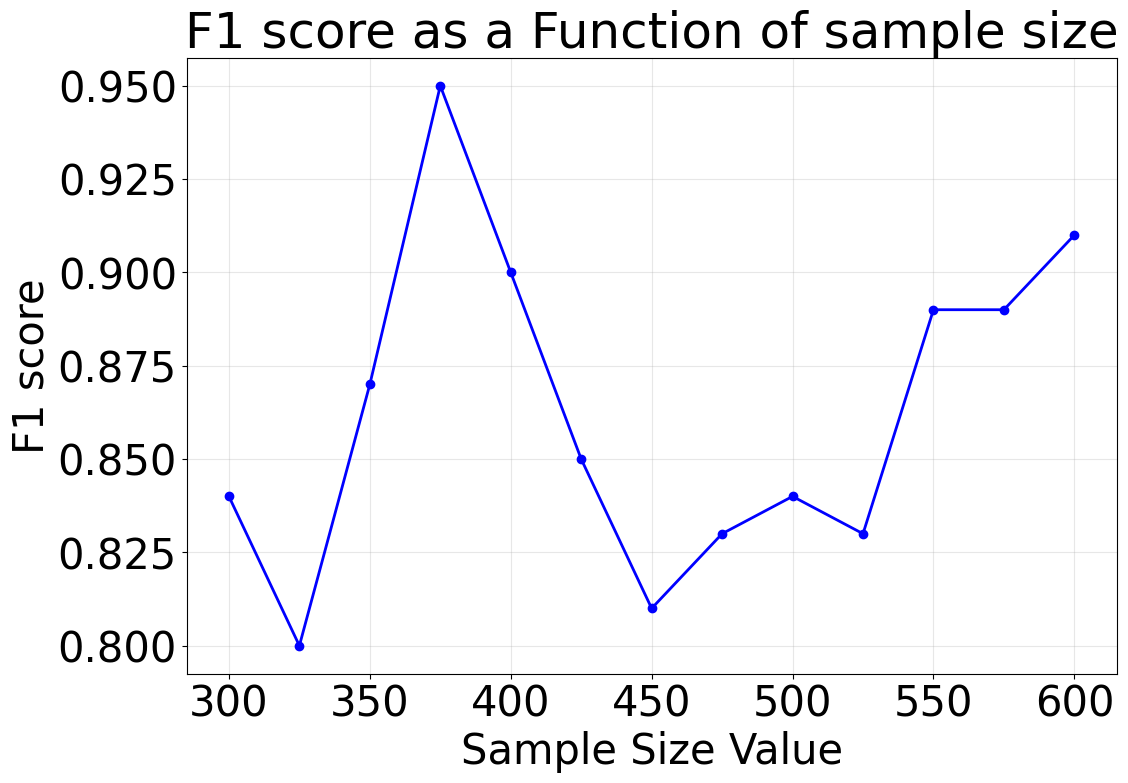

In [92]:

config_file = os.path.join(directory, f'best_FW_MetSyll.json')
with open(config_file, 'r') as f:
   config_dict = json.load(f)


# Results storage
sample_size_range = list(range(300, 601, 25))
f1_list = []
best_size = 300
best_f1 = 0
verbose = False

# Iteration over culling values
for s in sample_size_range:
    
    # Configuration update
    config_dict = config_dict.copy()
    config_dict["sampling"]["sample_size"] = s
    
    # Configuration save
    config_file = os.path.join(directory, f'first_config.json')
    with open(config_file, 'w') as f:
        json.dump(config_dict, f, ensure_ascii=False, indent=4)
    
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull), redirect_stderr(devnull):
            # Corpus loading
            train_set, feat_list = load_corpus_from_config(config_file)
            
            # Model training
            results = train_svm(
                train=train_set,
                test=None,
                cross_validate="group-k-fold",
                balance="downsampling",
                class_weights=True,
                get_coefs=False
            )
    
    results_list = results['classification_report'].split()
    acc_idx = results_list.index('accuracy') + 1
    f1_result = float(results_list[acc_idx])
    f1_list.append(f1_result)
    
    if verbose:
        print(f" F1-score: {f1_result}")
    
    if f1_result > best_f1:
        best_f1 = f1_result
        best_size = s

# Results visualization
plt.figure(figsize=(12, 8))

# Main plot: Precision vs Culling
plt.plot(sample_size_range, f1_list, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Sample Size Value')
plt.ylabel('F1 score')
plt.title('F1 score as a Function of sample size')
plt.grid(True, alpha=0.3)

# Best configuration save
config_dict["sampling"]["sample_size"] = best_size
config_file = os.path.join(directory, f'bestbest_FW_MetSyll.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print(f"\nBest sample size value: {best_size}")
print(f"Best F1-score: {best_f1}")
print(f"Best configuration saved as: {config_file}")

plt.show()

### Configuration with function words + metrics (line scale)

Finding the best culling value + n value for both feature type


Best combo: (40, 90)
Best F1-score: 0.97
Best configuration saved as: ../chrestien/best_FW_MetLine.json


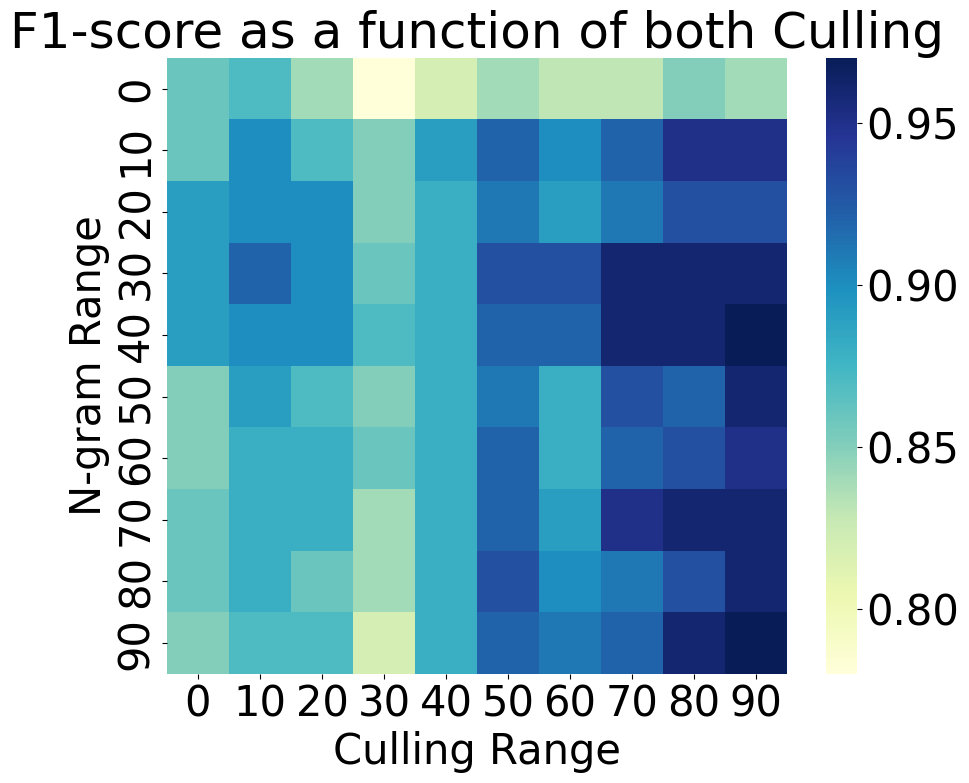

In [99]:
# Base configuration
base_config = {
    "paths": "../data/xml/nowordnoelisions/train/*",
    "format": "tei",
    "sampling": {
        "enabled": True,
        "units": "verses",
        "sample_size": 375
    },
    "features": [
    {
      "type": "met_line",
      "n": 1,
      "culling": 0 # is changing
    },
    {
      "type": "words",
      "n": 1,
      "k": 1000,
      "culling": 0, # is_changing
      "feat_list": "../data/function_words_old-french_of3c.json",
      "freq_type": "relative"
    }
    ]
}

# Directory for experiments
directory = "../chrestien/"
os.makedirs(directory, exist_ok=True)

# Results storage
results_data = []

culling_range_met = list(range(0, 100, 10))
culling_range_w = list(range(0, 100, 10))

best_combo = (0, 0)

f1_list = np.zeros((len(culling_range_met), len(culling_range_w)))
best_f1 = 0

verbose = False

for (i,c_met) in enumerate(culling_range_met):
    for (j,c_w) in enumerate(culling_range_w):
        
        # Configuration update
        config_dict = base_config.copy()
        config_dict["features"][0]["culling"] = c_met
        config_dict["features"][1]["culling"] = c_w
        
        # Configuration save
        config_file = os.path.join(directory, f'first_config.json')
        with open(config_file, 'w') as f:
            json.dump(config_dict, f, ensure_ascii=False, indent=4)
        
        with open(os.devnull, 'w') as devnull:
            with redirect_stdout(devnull), redirect_stderr(devnull):
                # Corpus loading
                train_set, feat_list = load_corpus_from_config(config_file)
                
                # Model training
                results = train_svm(
                    train=train_set,
                    test=None,
                    cross_validate="group-k-fold",
                    balance="downsampling",
                    class_weights=True,
                    get_coefs=False
                )
        
        results_list = results['classification_report'].split()
        acc_idx = results_list.index('accuracy') + 1
        f1_result = float(results_list[acc_idx])
        f1_list[i, j] = f1_result
        
        if verbose:
            print(f" F1-score: {f1_result}")
        
        if f1_result > best_f1:
            best_f1 = f1_result
            best_combo = (c_met, c_w)



fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(f1_list, annot=False, fmt=".3f", cmap="YlGnBu",
                     xticklabels=culling_range_w, yticklabels=culling_range_met)

plt.xlabel('Culling Range')
plt.ylabel('N-gram Range')
plt.title('F1-score as a function of both Culling')


# Best configuration save
config_dict["features"][0]["culling"] = best_combo[0]
config_dict["features"][1]["culling"] = best_combo[1]

config_file = os.path.join(directory, f'best_FW_MetLine.json')
with open(config_file, 'w') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

print(f"\nBest combo: {best_combo}")
print(f"Best F1-score: {best_f1}")
print(f"Best configuration saved as: {config_file}")

plt.show()


## Rolling Analysis

Function words + metrics syllable

None
Loading f1...
.......loading texts.......
.......getting features.......
K Limit ignored because the size of the list is lower (2235 < 5000)
.......getting counts.......
.......Culling at 60%.......
.......feeding data frame.......


100%|██████████| 92/92 [00:00<00:00, 274.81it/s]


../data/function_words_old-french_of3c.json
Loading f2...
.......loading texts.......
.......getting features.......
.......getting counts.......
.......Culling at 70%.......
.......feeding data frame.......


100%|██████████| 92/92 [00:00<00:00, 19187.31it/s]

Creating merged dataset...
../chrestien/feat_list1.json
Loading f1...
.......loading texts.......


.......getting features.......
.......getting counts.......
.......feeding data frame.......


100%|██████████| 4085/4085 [00:07<00:00, 530.47it/s]


../chrestien/feat_list2.json
Loading f2...
.......loading texts.......
.......getting features.......
.......getting counts.......
.......feeding data frame.......


100%|██████████| 4085/4085 [00:00<00:00, 29887.46it/s]

Creating merged dataset...
.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... implementing strategy to solve imbalance in data ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('sampling', RandomUnderSampler(random_state=42)), ('model', LinearSVC(class_weight='balanced'))]


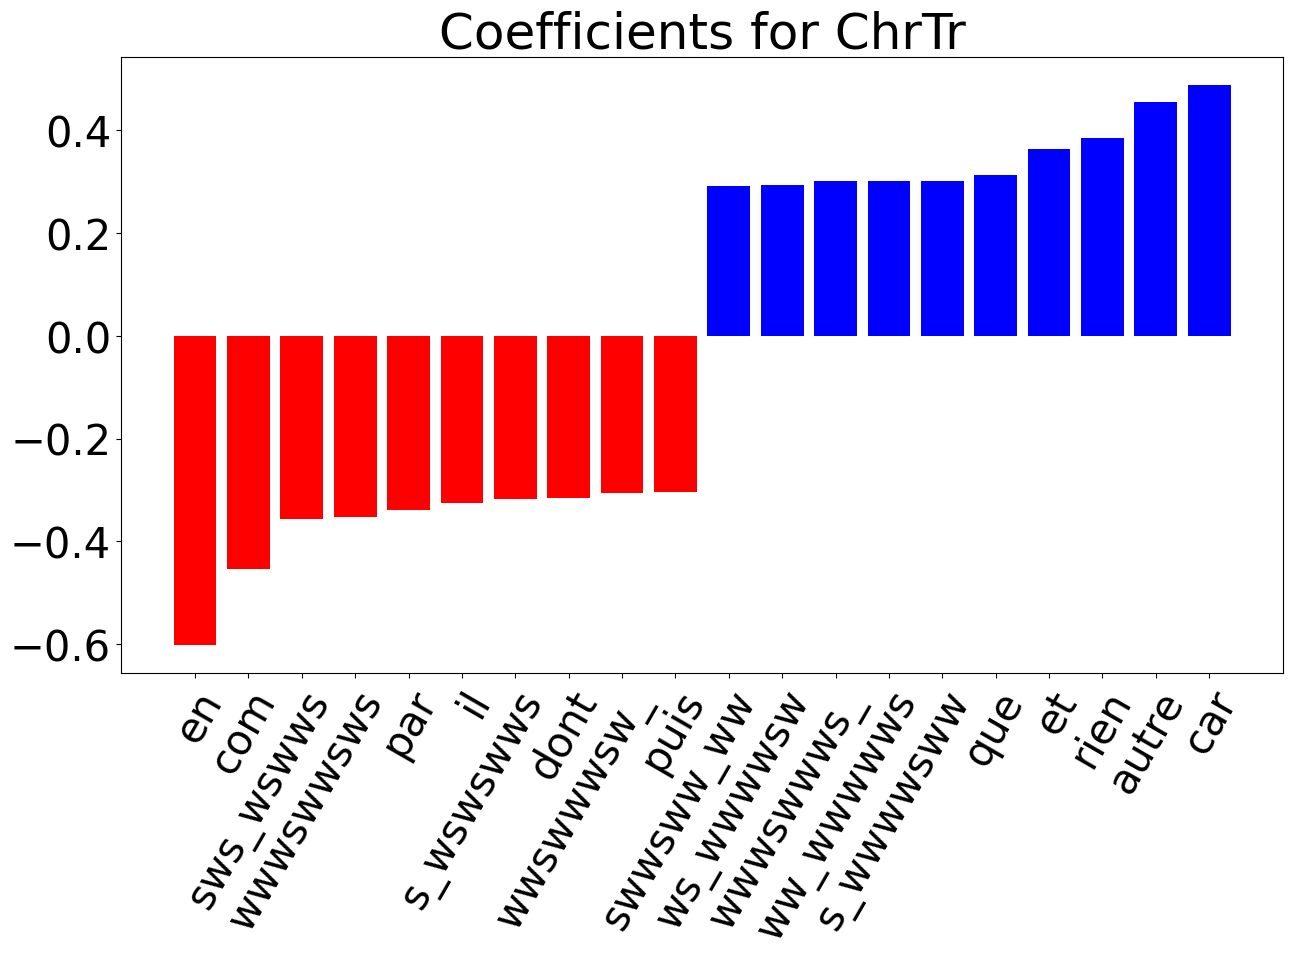

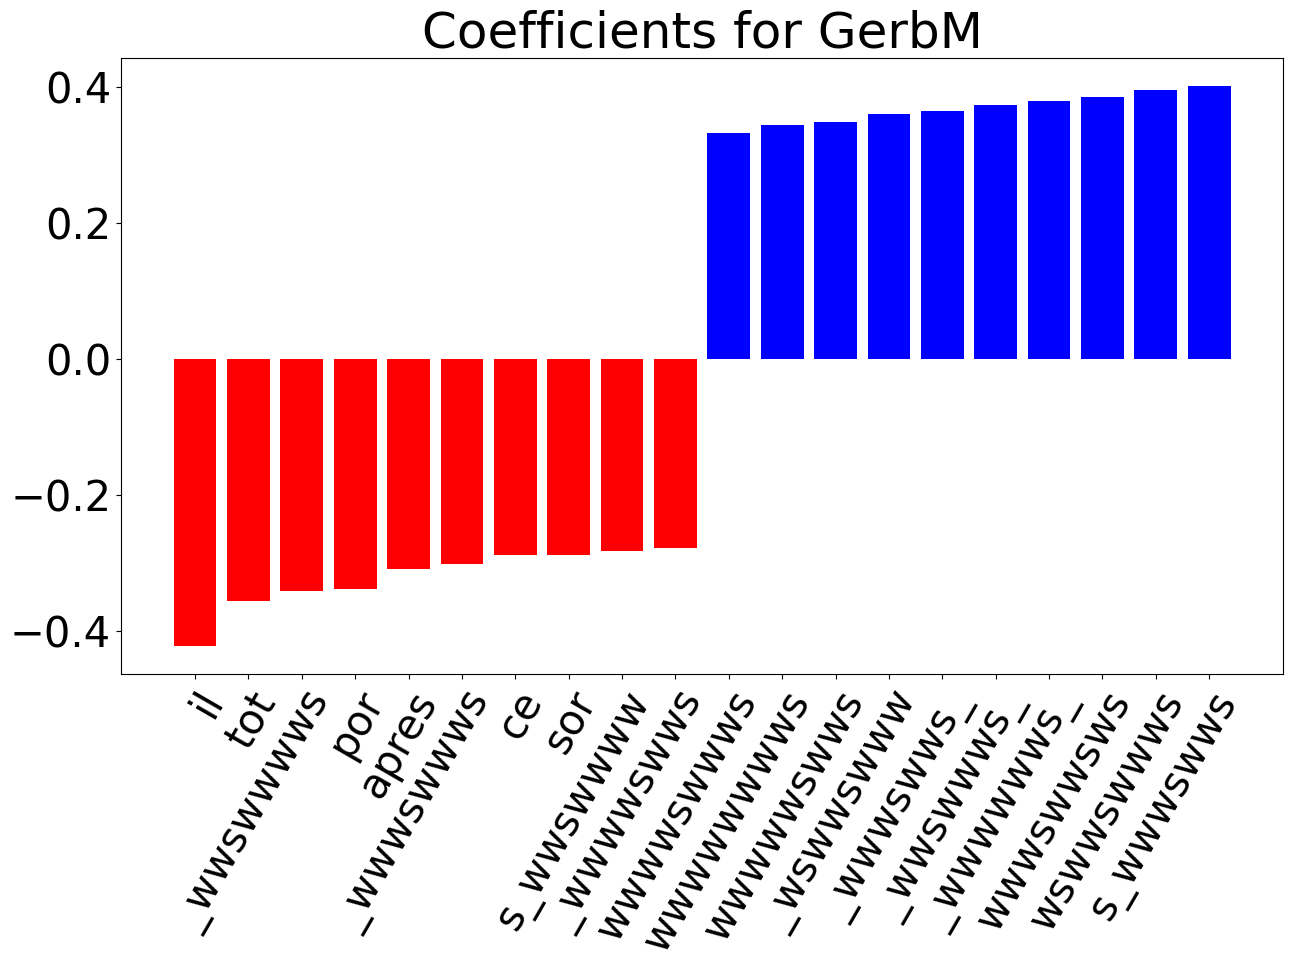

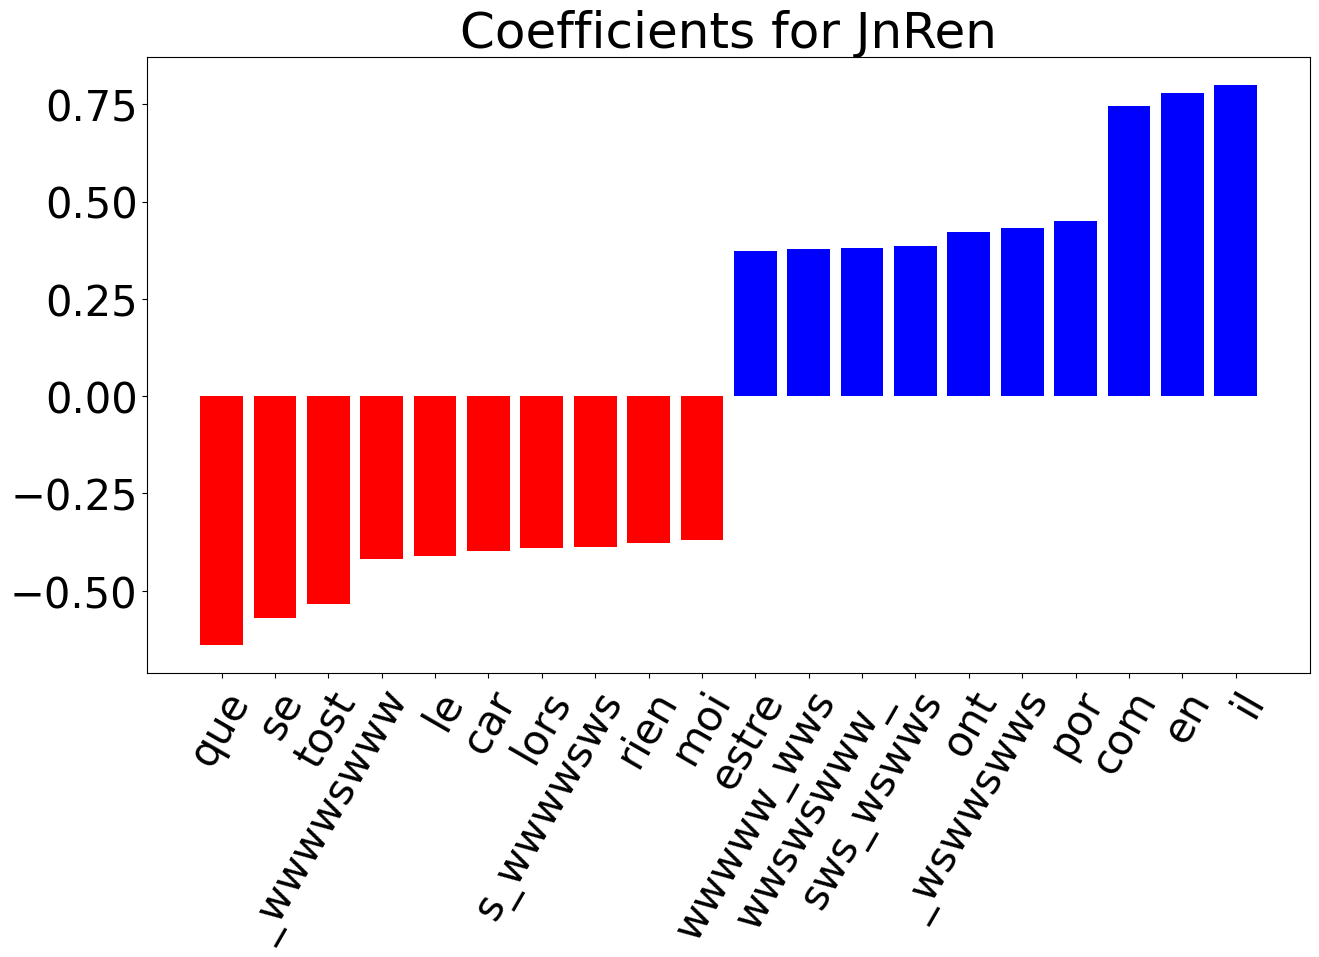

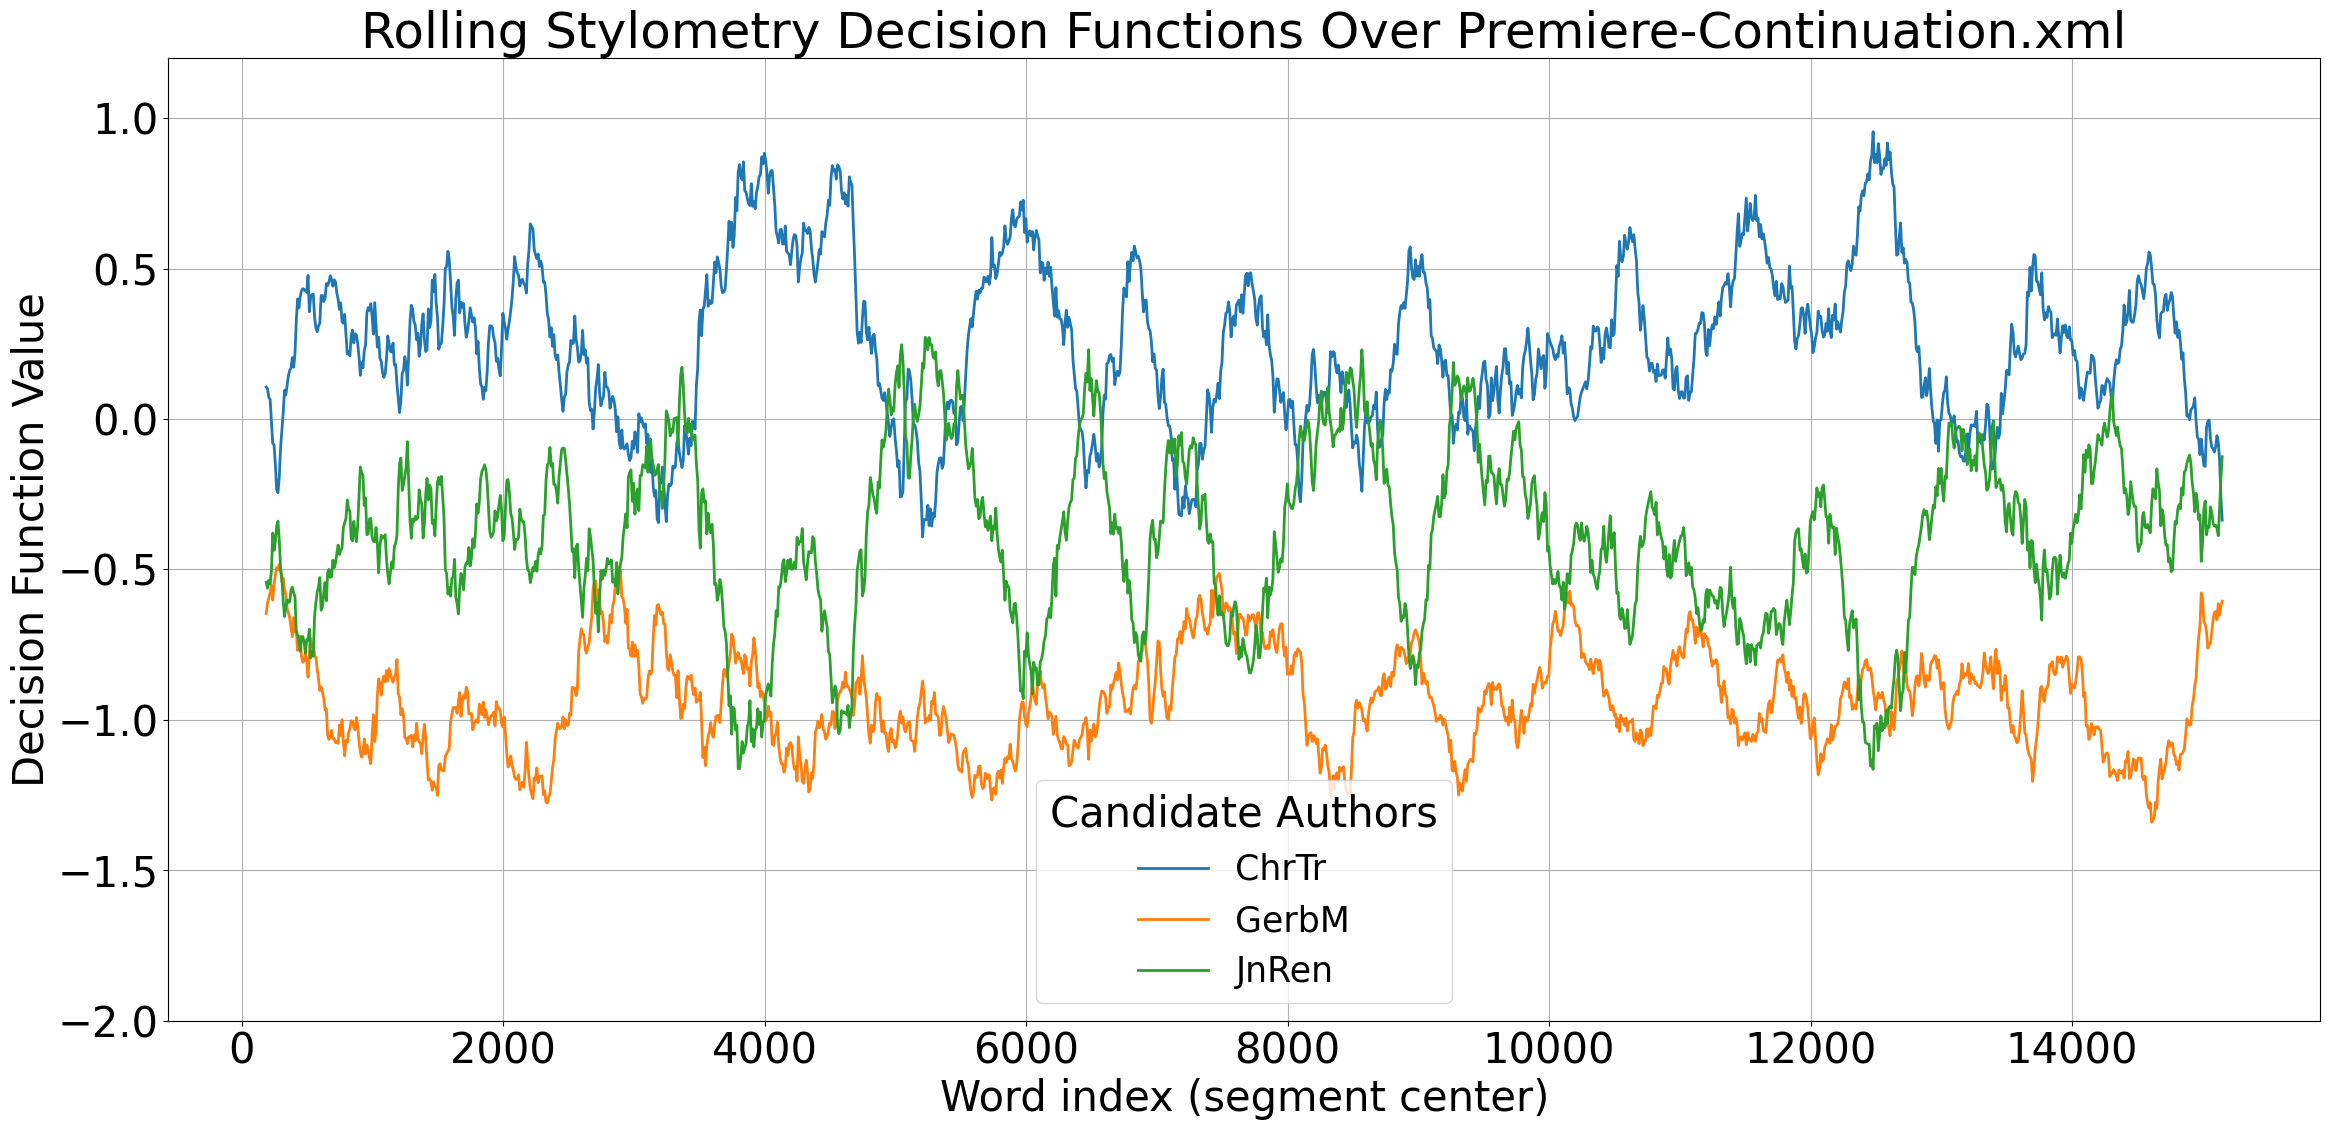

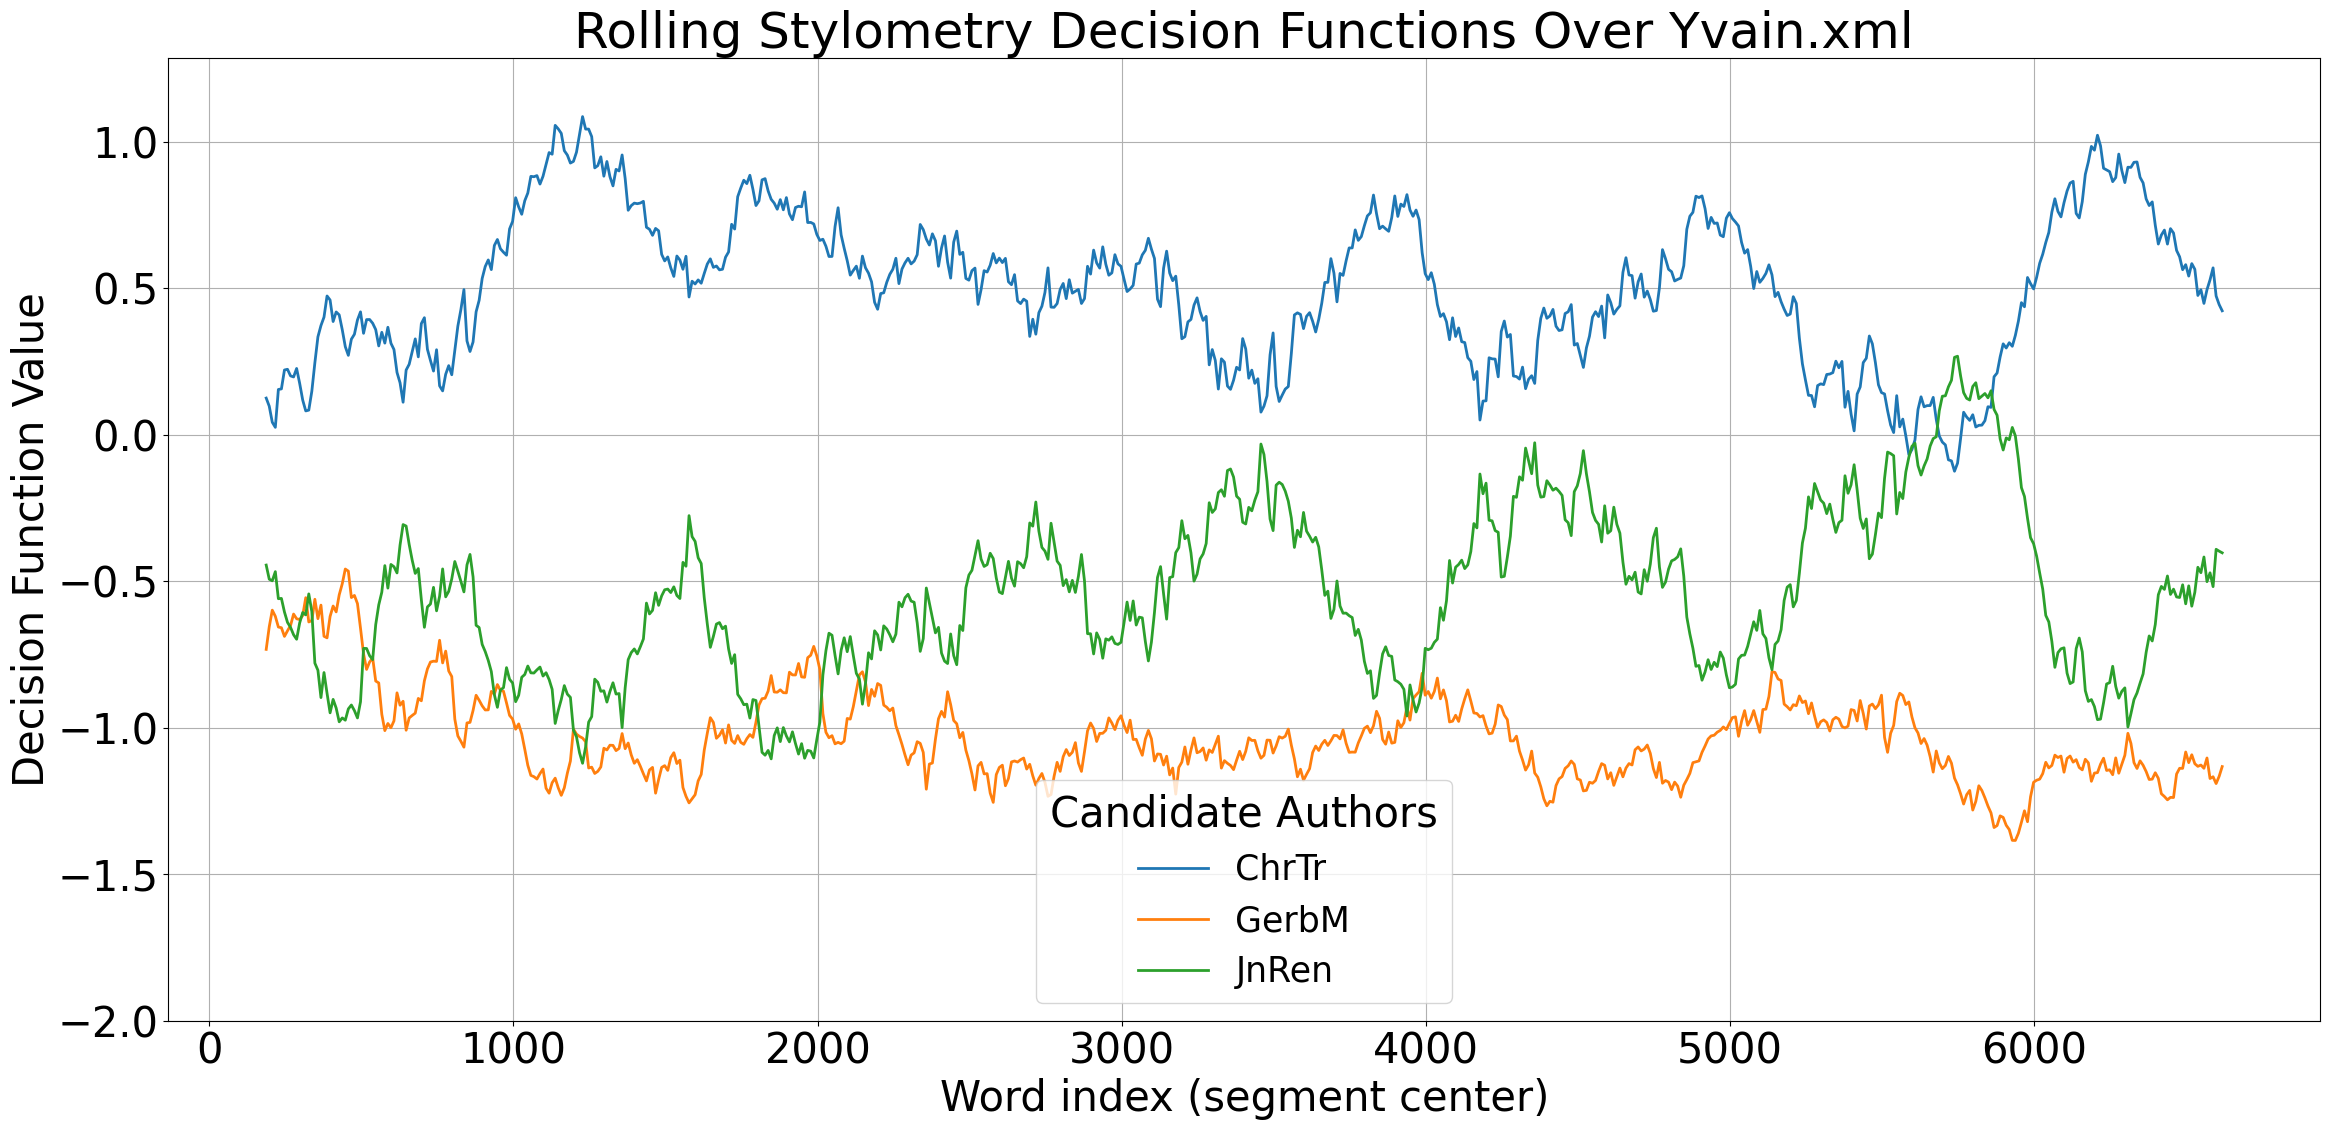

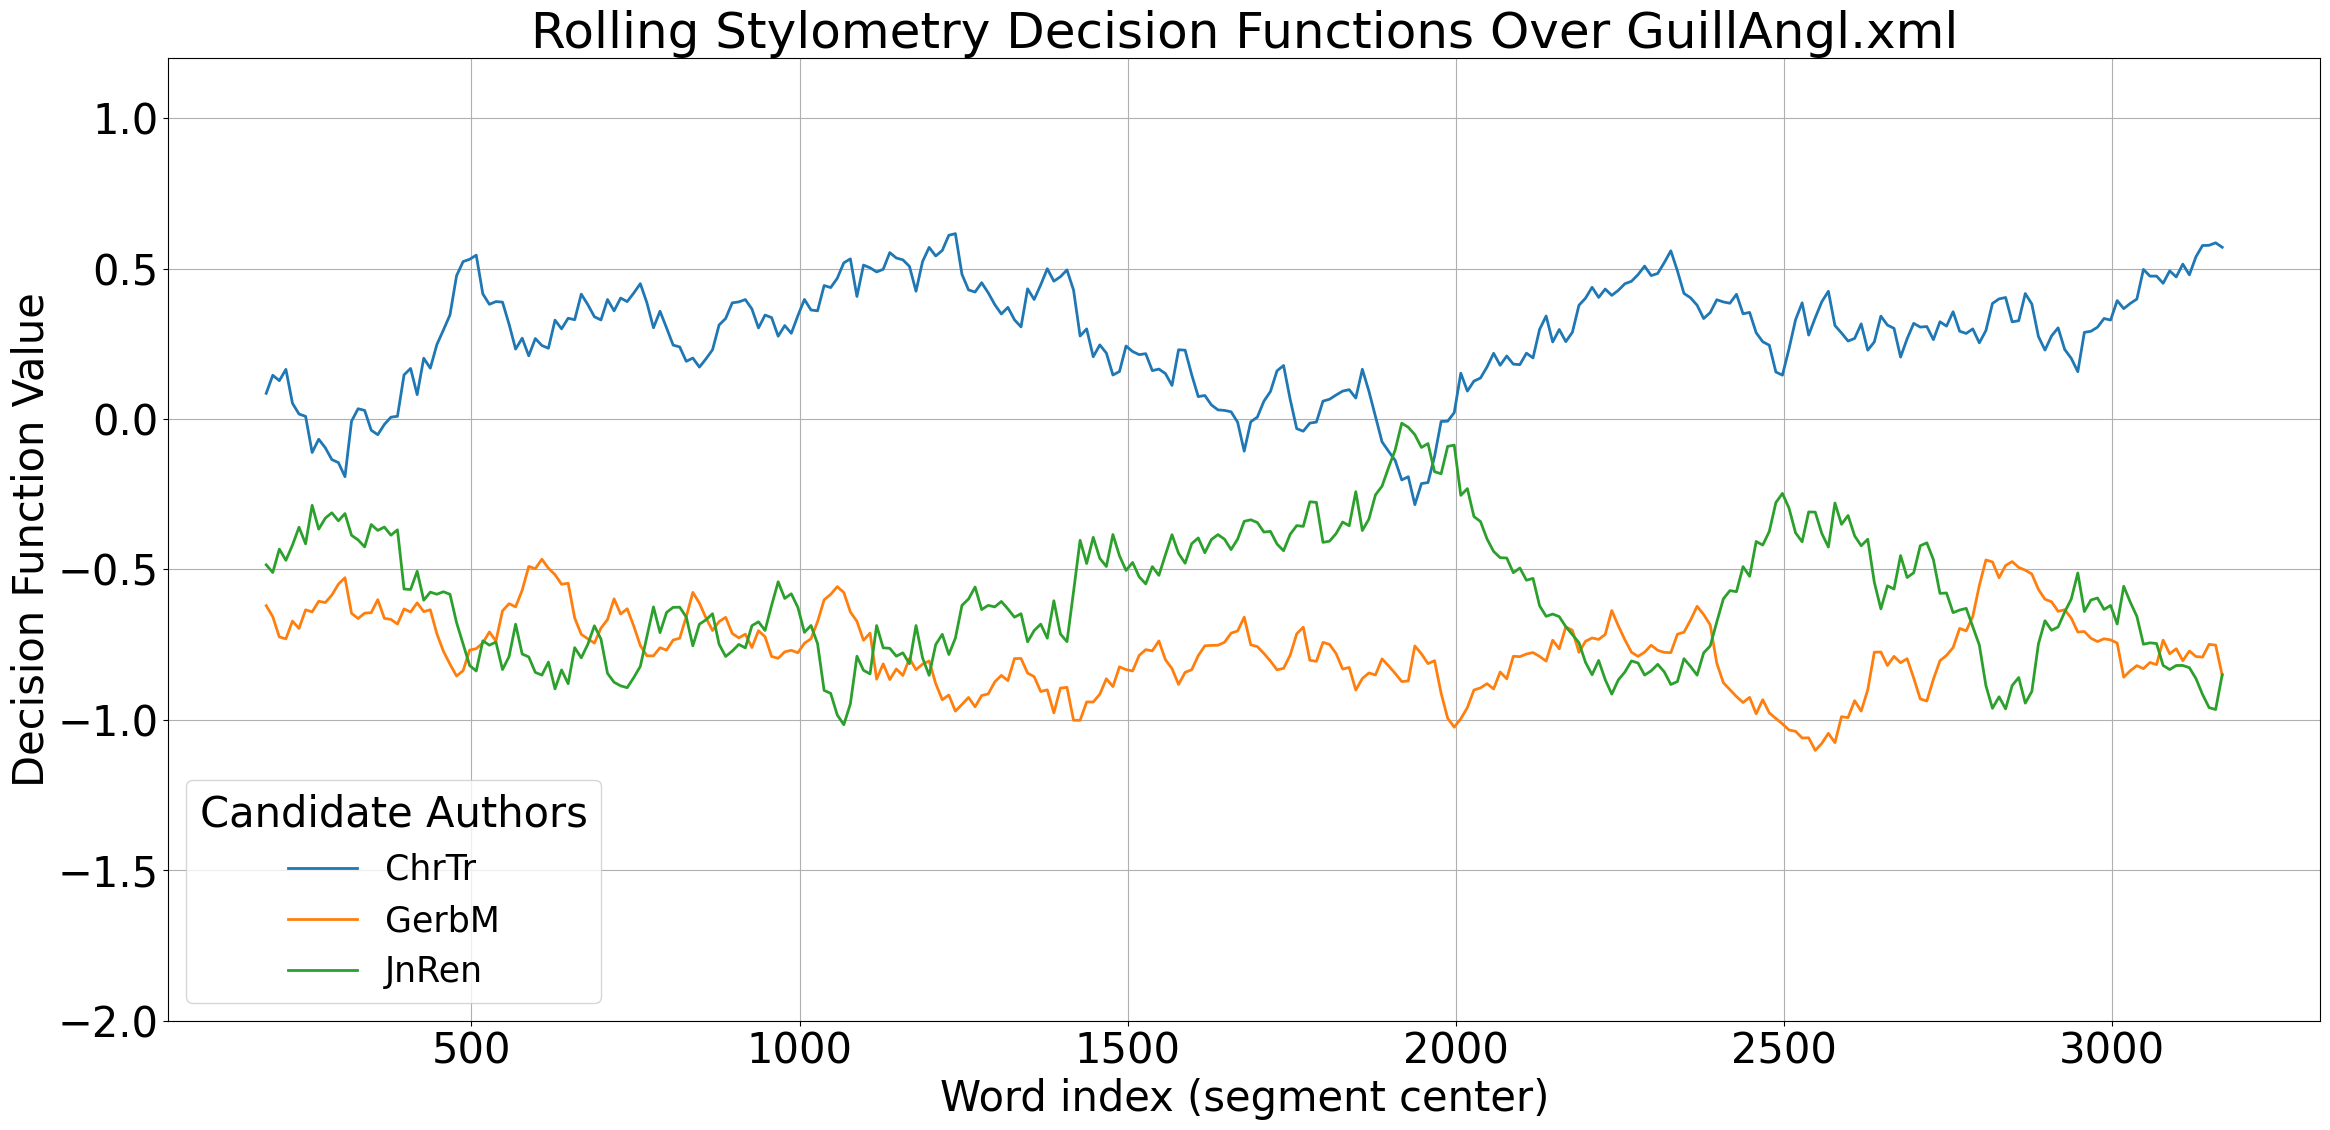

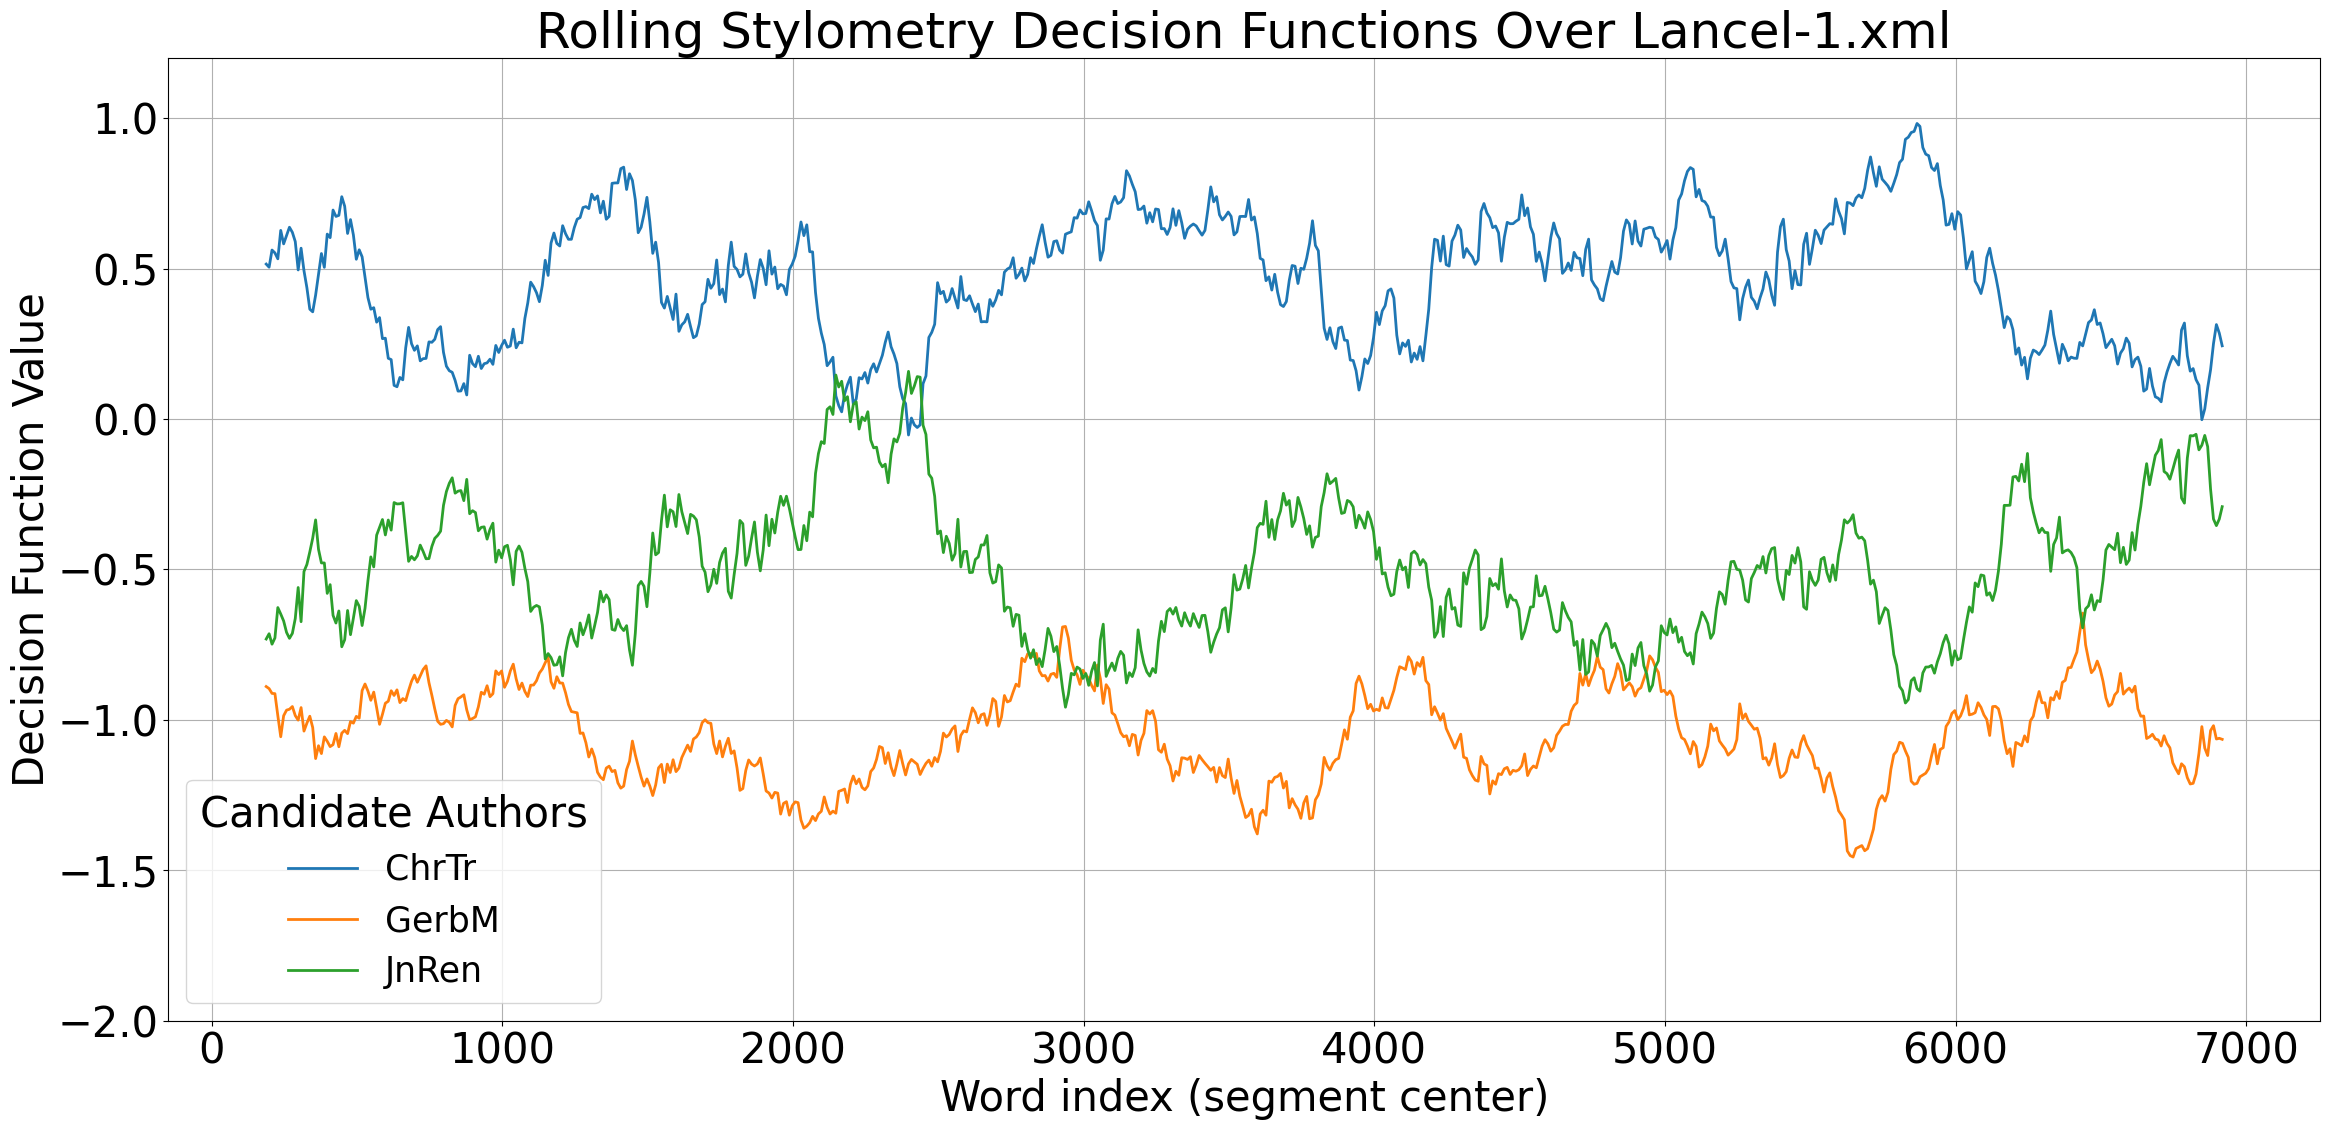

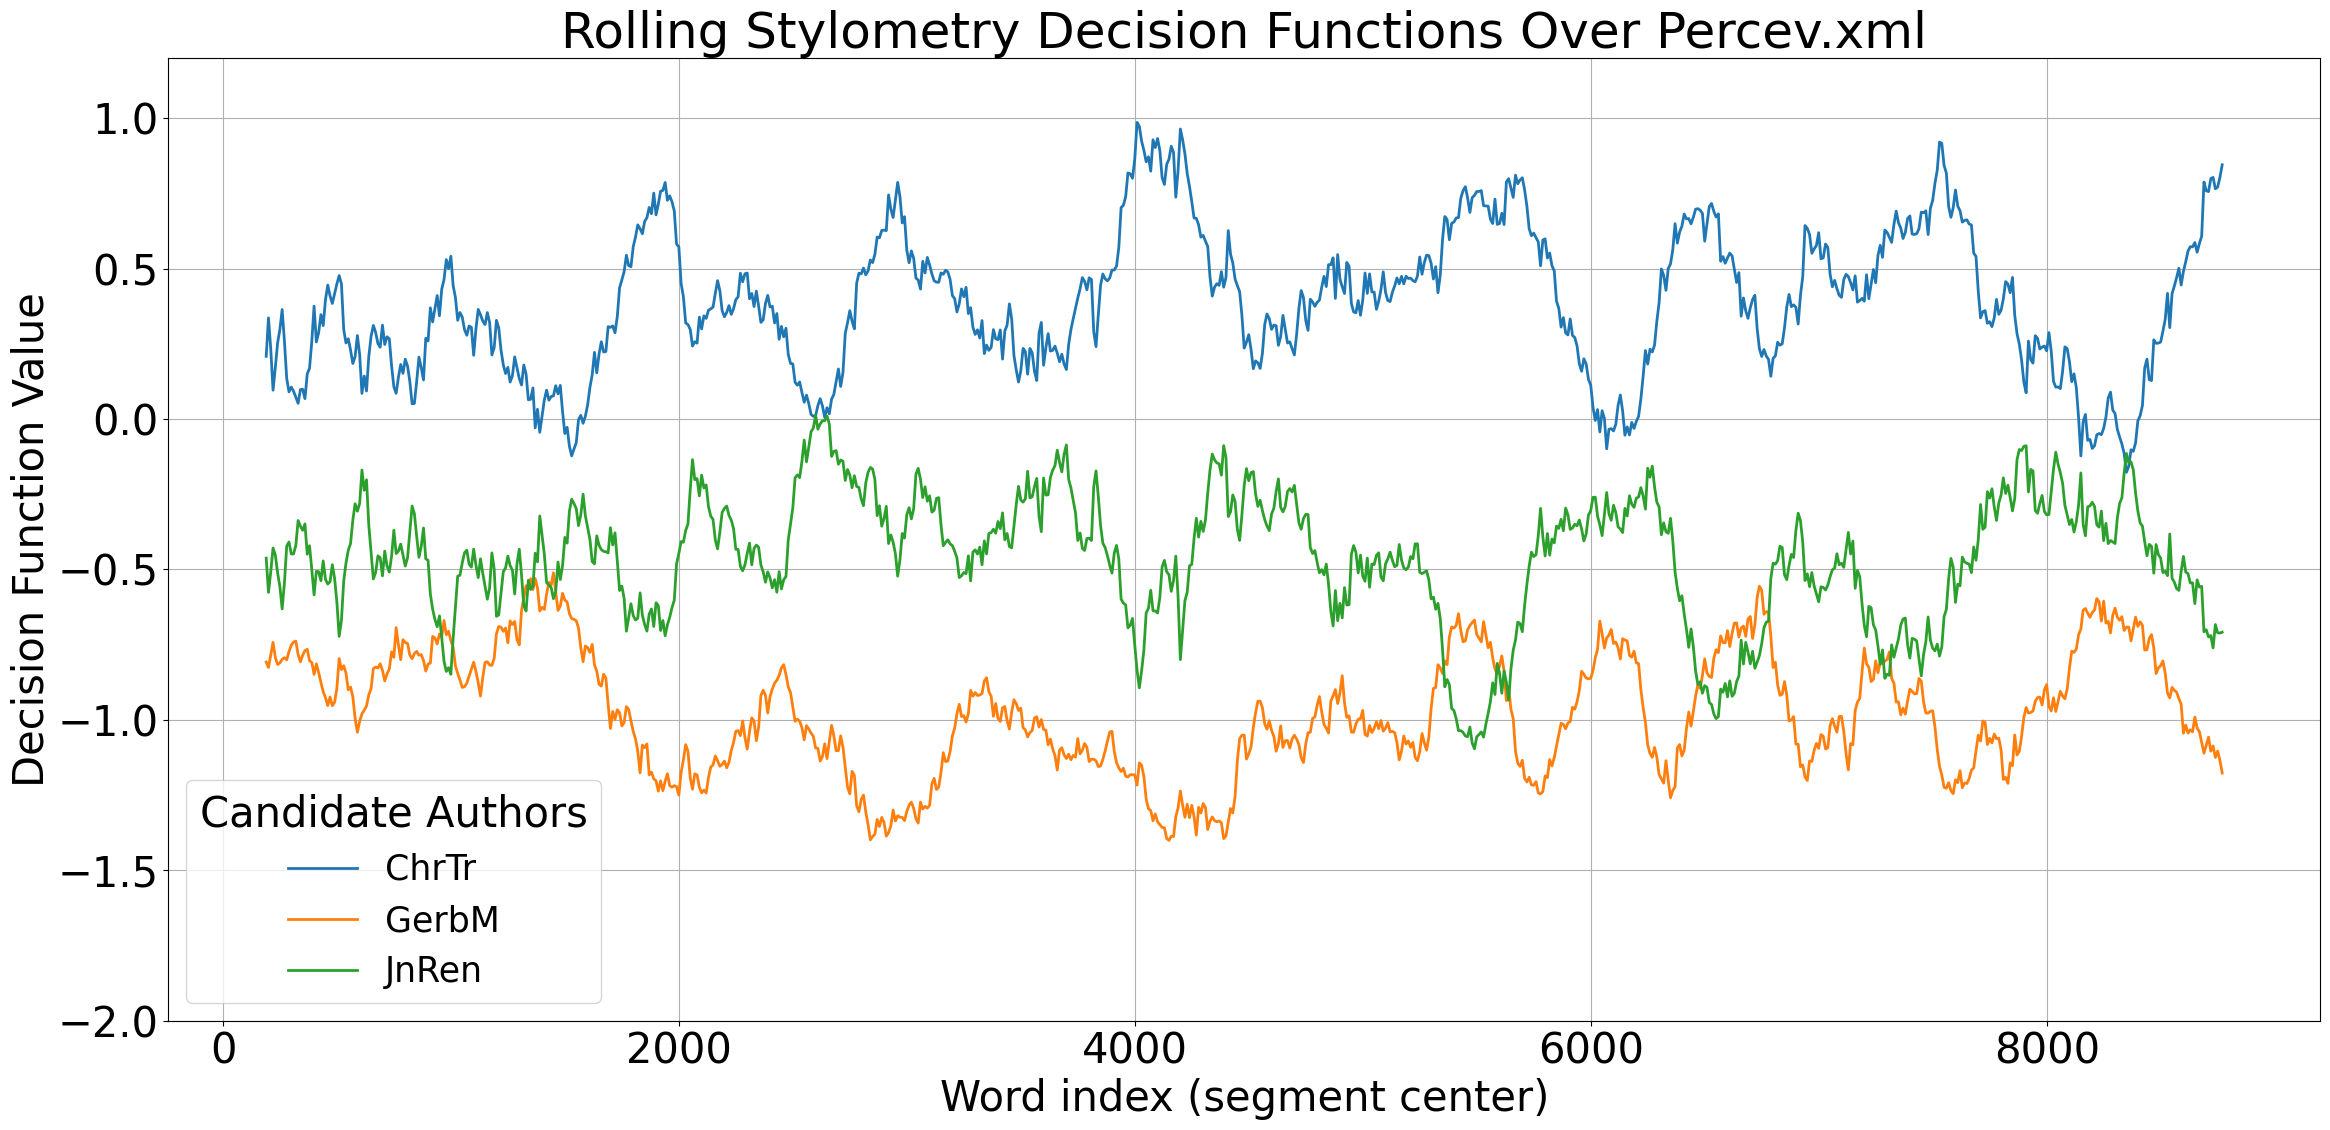

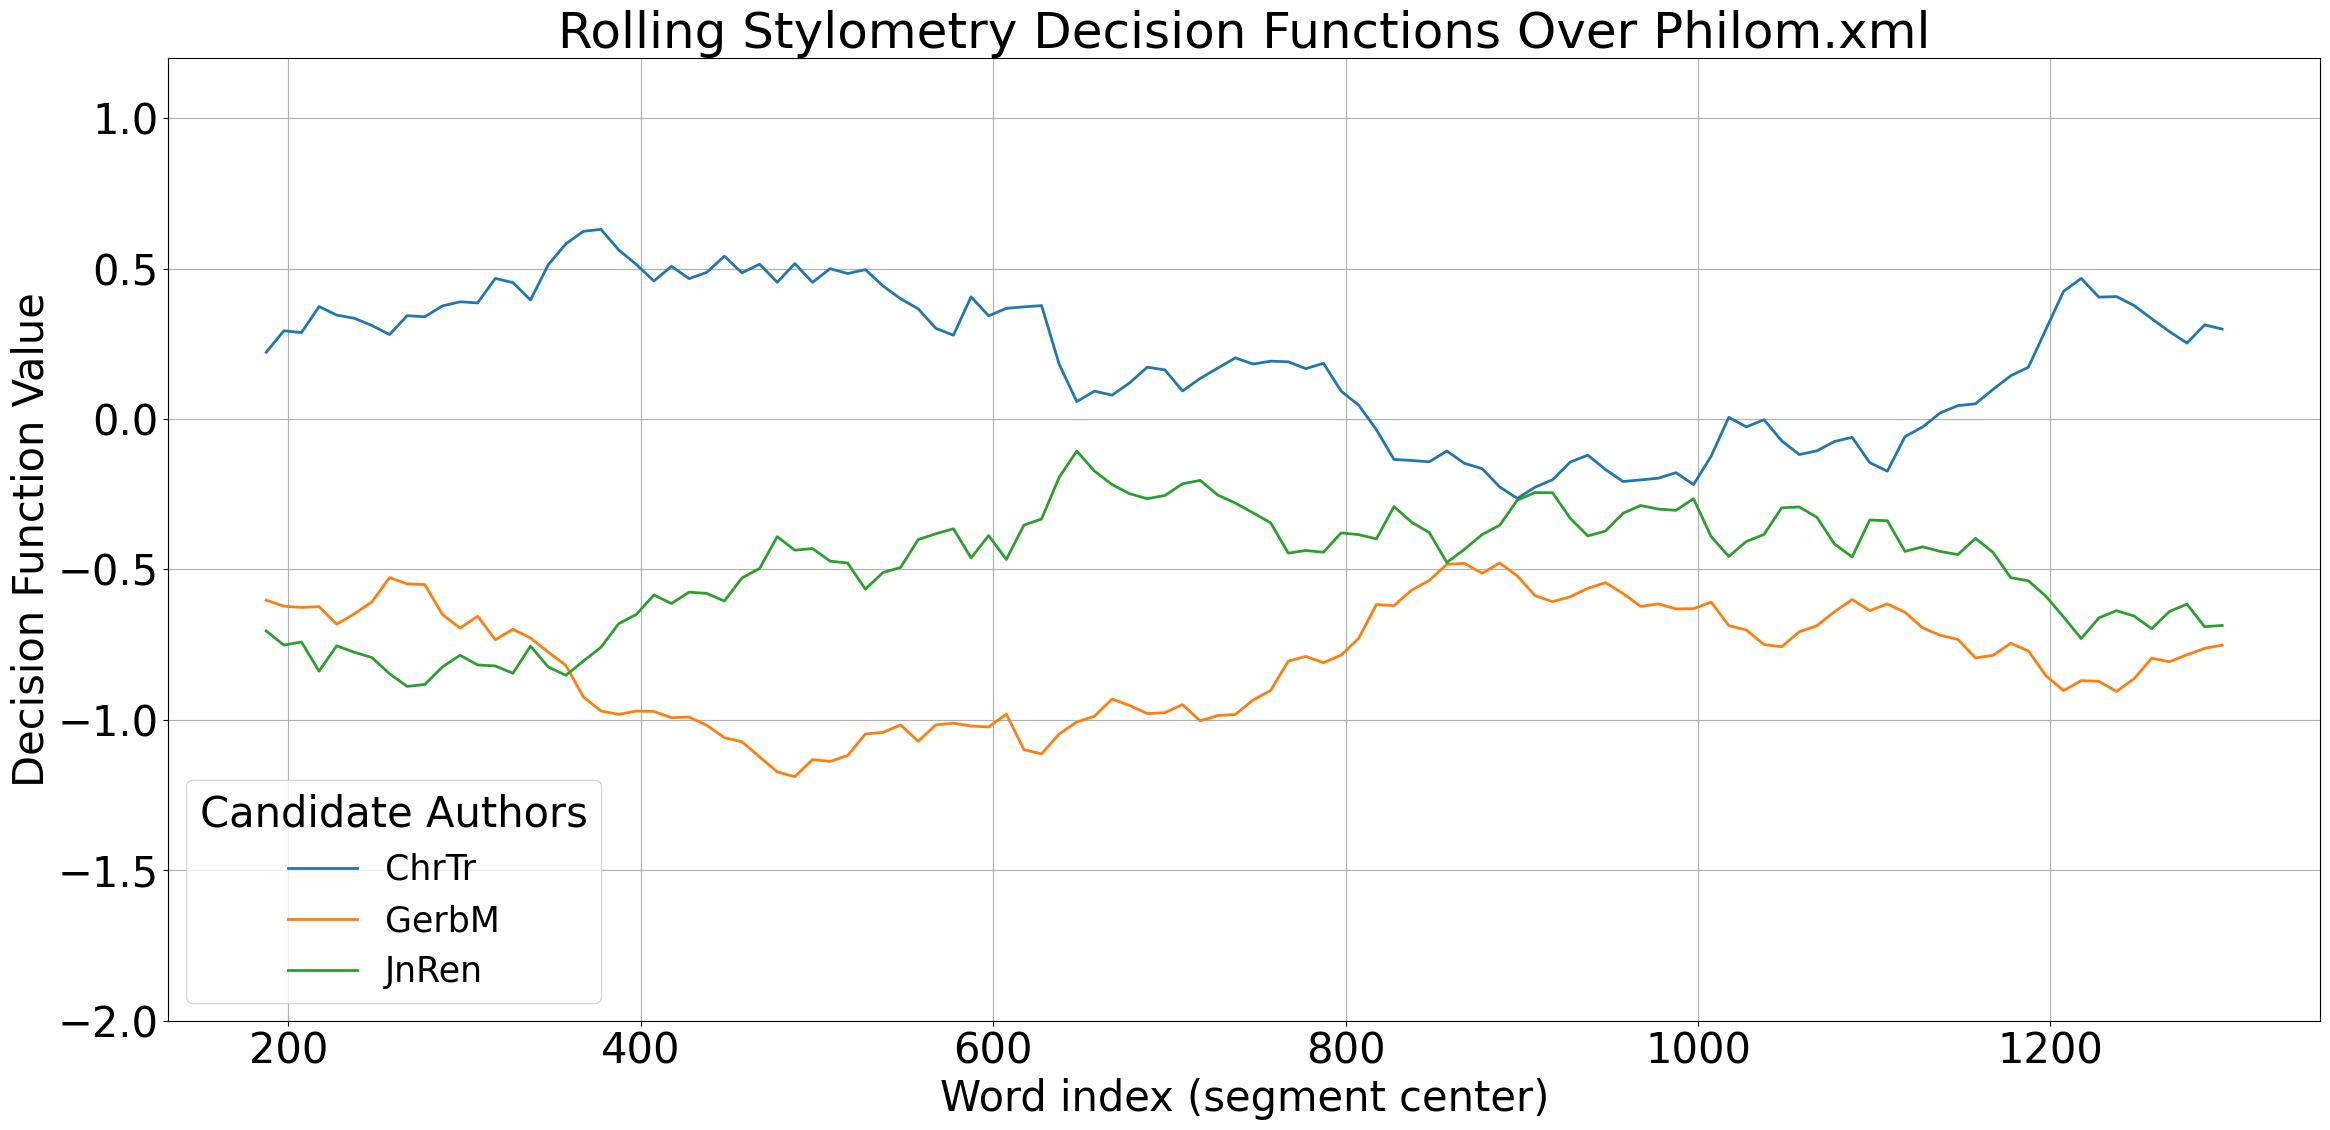

In [101]:
train_config_file = os.path.join(directory, f'bestbest_FW_MetSyll.json')
train_set, feat_lists = load_corpus_from_config(train_config_file)

feat_list_files = [os.path.join(directory, "feat_list1.json"), os.path.join(directory, "feat_list2.json")]

for (i,file) in enumerate(feat_list_files):
    with open(file, 'w') as f:
        json.dump(feat_lists[i], f, ensure_ascii=False, indent=4)


with open(train_config_file, 'r') as f:
   test_config_dict = json.load(f)


test_config_dict["paths"] = "../data/xml/nowordnoelisions/unseen/*"
test_config_dict["sampling"]["step"] = 10
test_config_dict["features"][0]["feat_list"] =  feat_list_files[0]
test_config_dict["features"][1]["feat_list"] =  feat_list_files[1]
test_config_dict["features"][0]["culling"] =  0
test_config_dict["features"][1]["culling"] =  0

test_config_file = os.path.join(directory, f'test_bestbest_FW_MetSyll.json')
with open(test_config_file, 'w') as f:
    json.dump(test_config_dict, f, ensure_ascii=False, indent=4)


test_set, feat_list = load_corpus_from_config(test_config_file, is_test=True)



results = train_svm(train=train_set,
                    test=test_set,
                    balance="downsampling",
                    class_weights=True,
                    get_coefs=True,
                    final_pred=True,
                    )

plot_rolling(results["final_predictions"], smoothing=0)

Function words + metrics line

None
Loading f1...
.......loading texts.......
.......getting features.......
K Limit ignored because the size of the list is lower (743 < 5000)
.......getting counts.......
.......Culling at 40%.......
.......feeding data frame.......


100%|██████████| 92/92 [00:00<00:00, 15887.52it/s]

../data/function_words_old-french_of3c.json
Loading f2...
.......loading texts.......


.......getting features.......
.......getting counts.......
.......Culling at 90%.......
.......feeding data frame.......


100%|██████████| 92/92 [00:00<00:00, 26667.31it/s]

Creating merged dataset...
../chrestien/feat_list1.json
Loading f1...
.......loading texts.......


.......getting features.......
.......getting counts.......
.......feeding data frame.......


100%|██████████| 4085/4085 [00:00<00:00, 23093.74it/s]


../chrestien/feat_list2.json
Loading f2...
.......loading texts.......
.......getting features.......
.......getting counts.......
.......feeding data frame.......


100%|██████████| 4085/4085 [00:00<00:00, 62438.44it/s]

Creating merged dataset...
.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... implementing strategy to solve imbalance in data ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('sampling', RandomUnderSampler(random_state=42)), ('model', LinearSVC(class_weight='balanced'))]


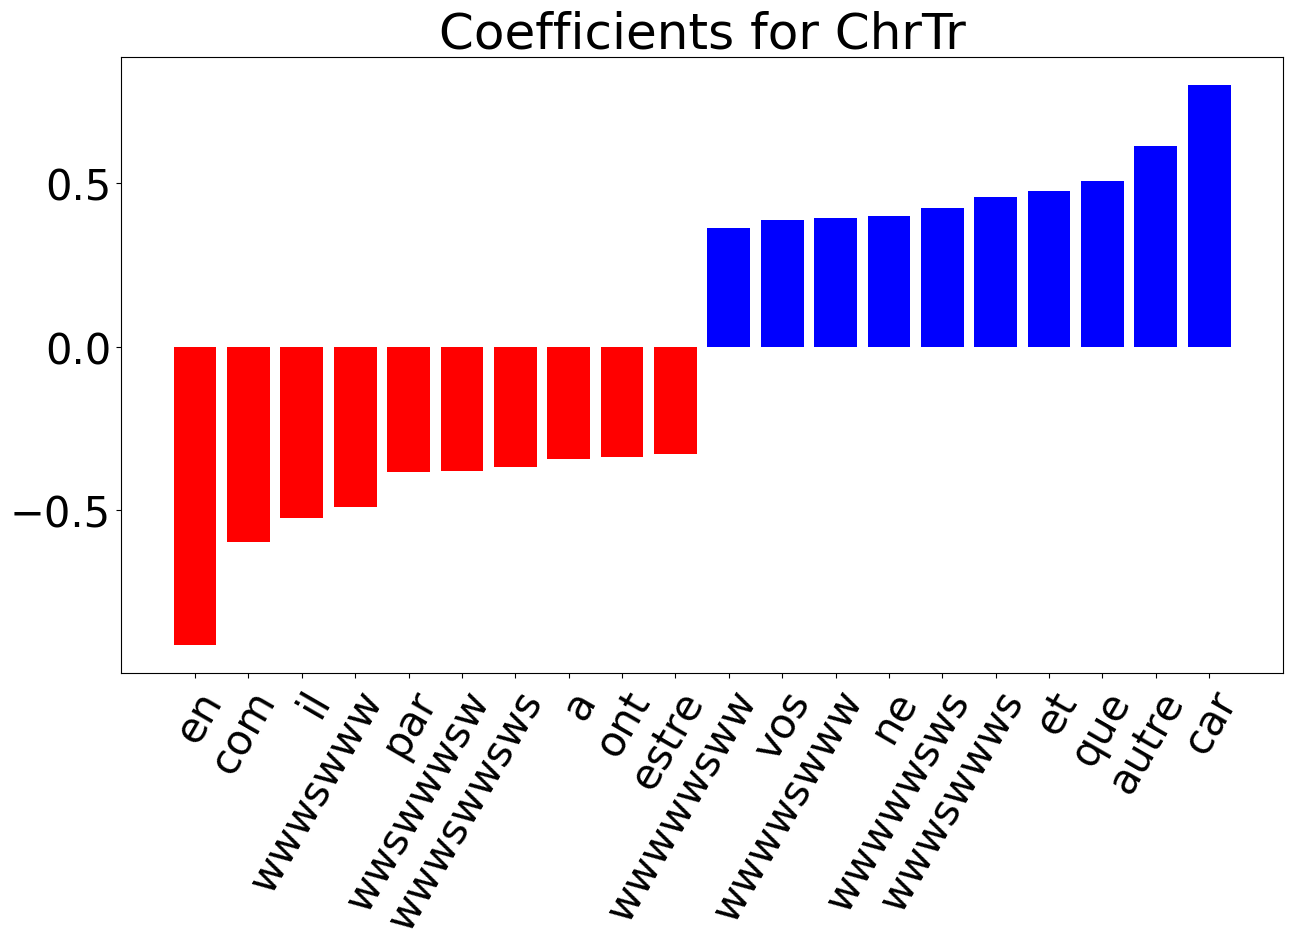

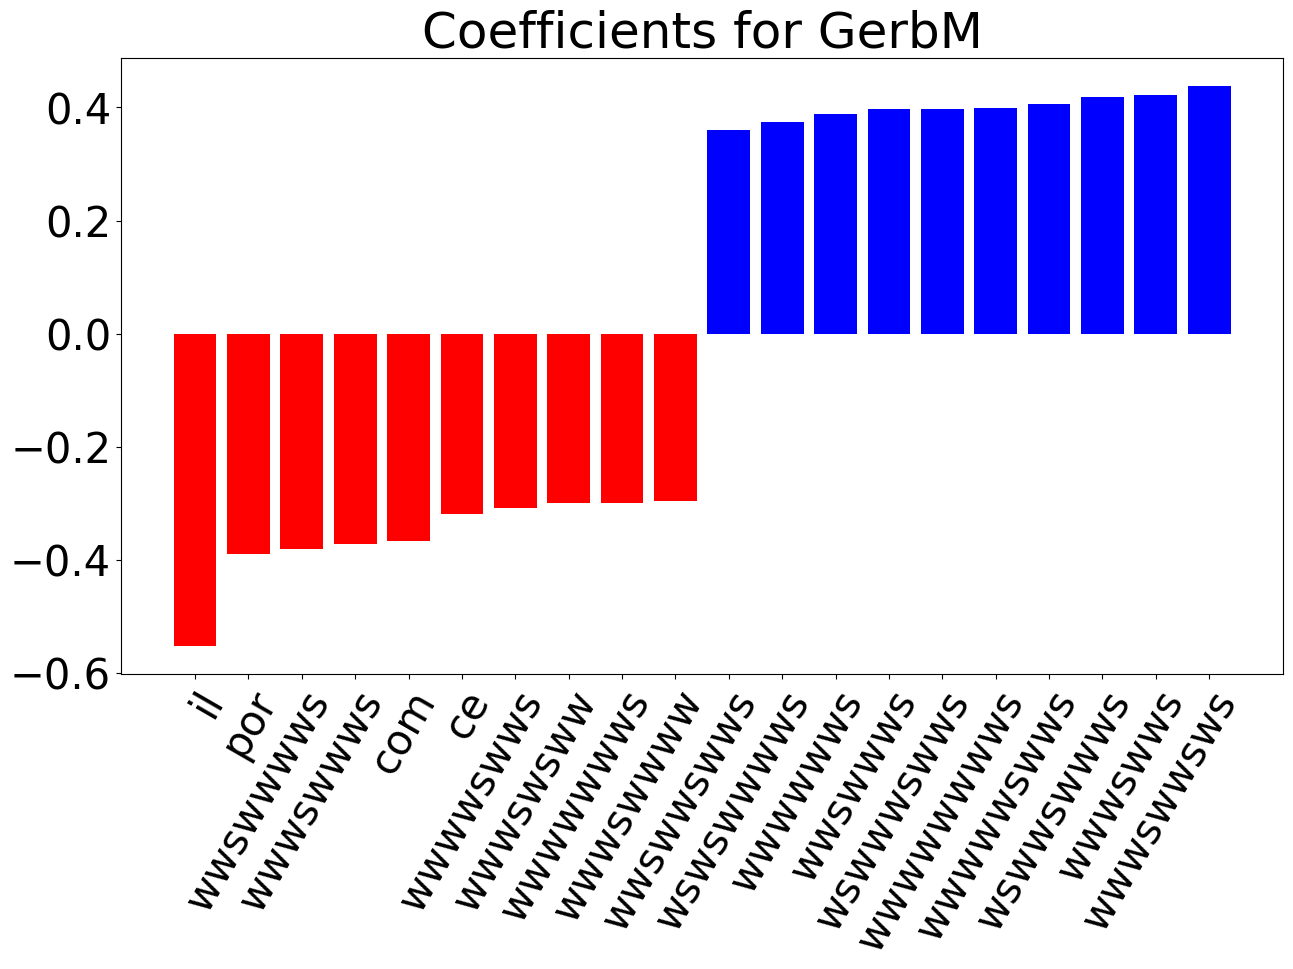

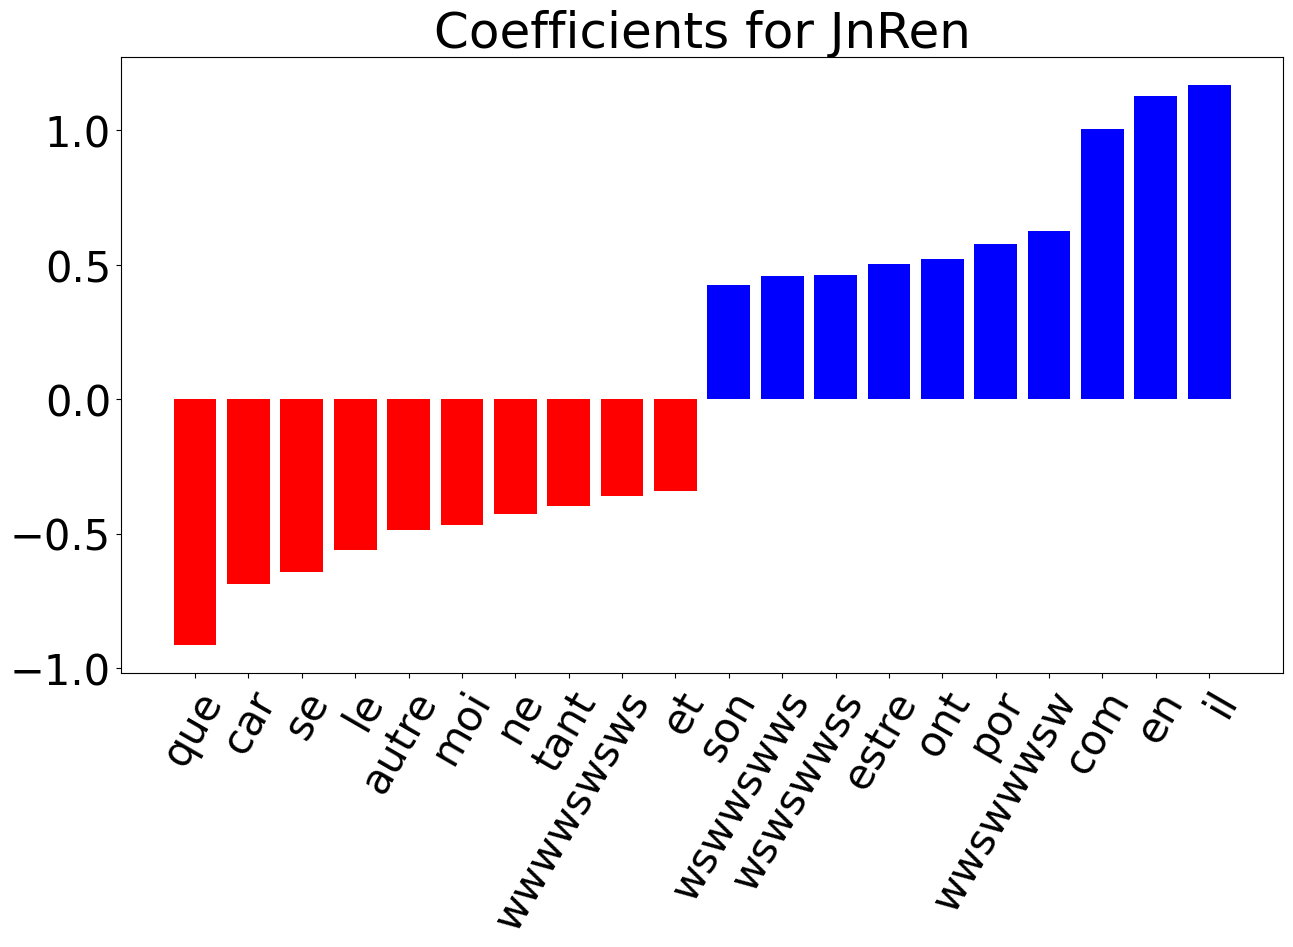

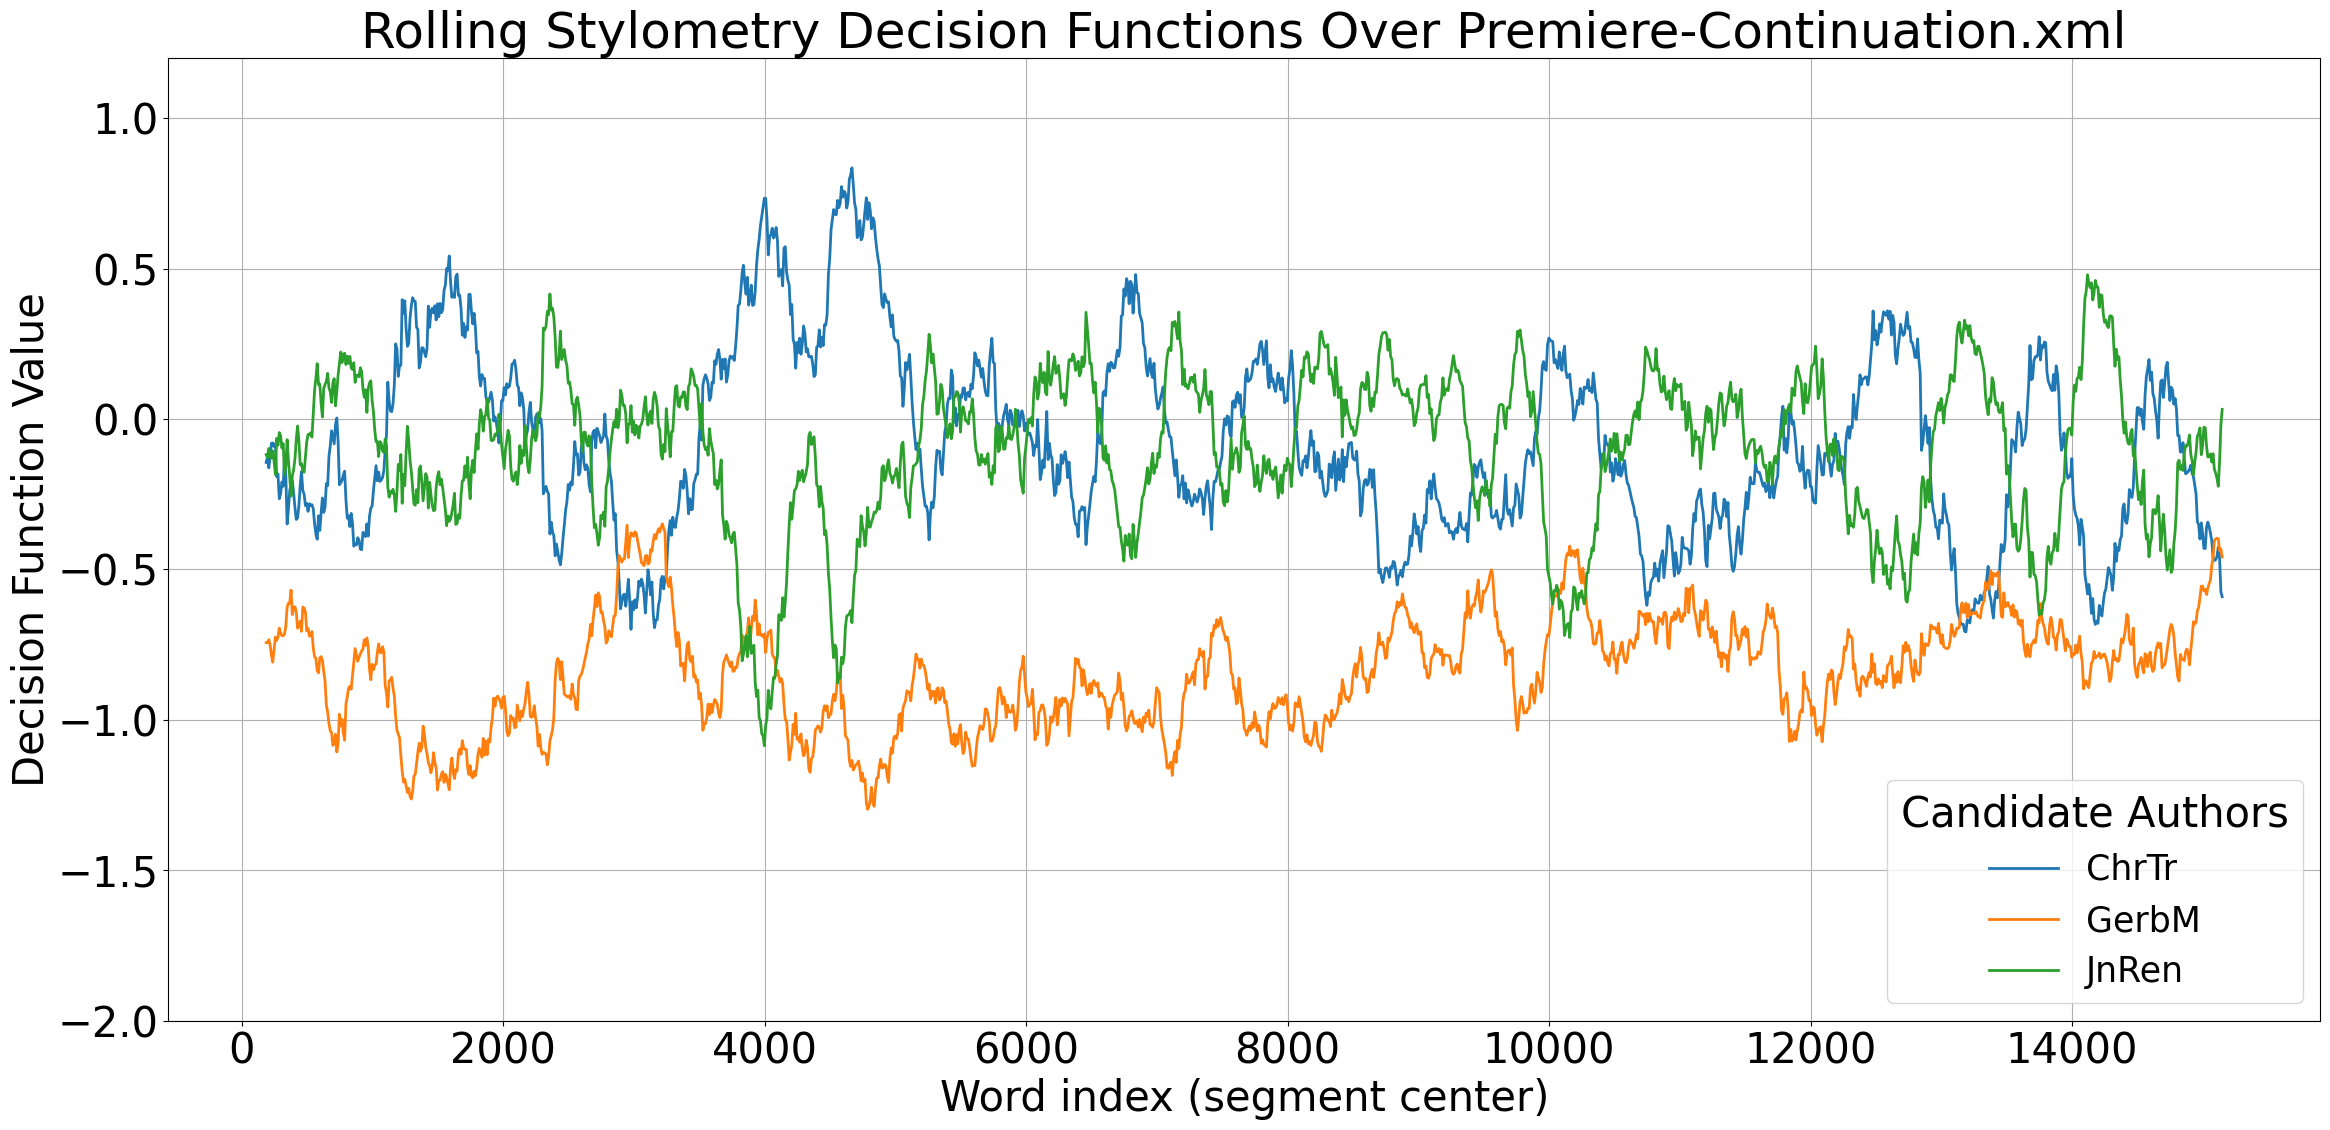

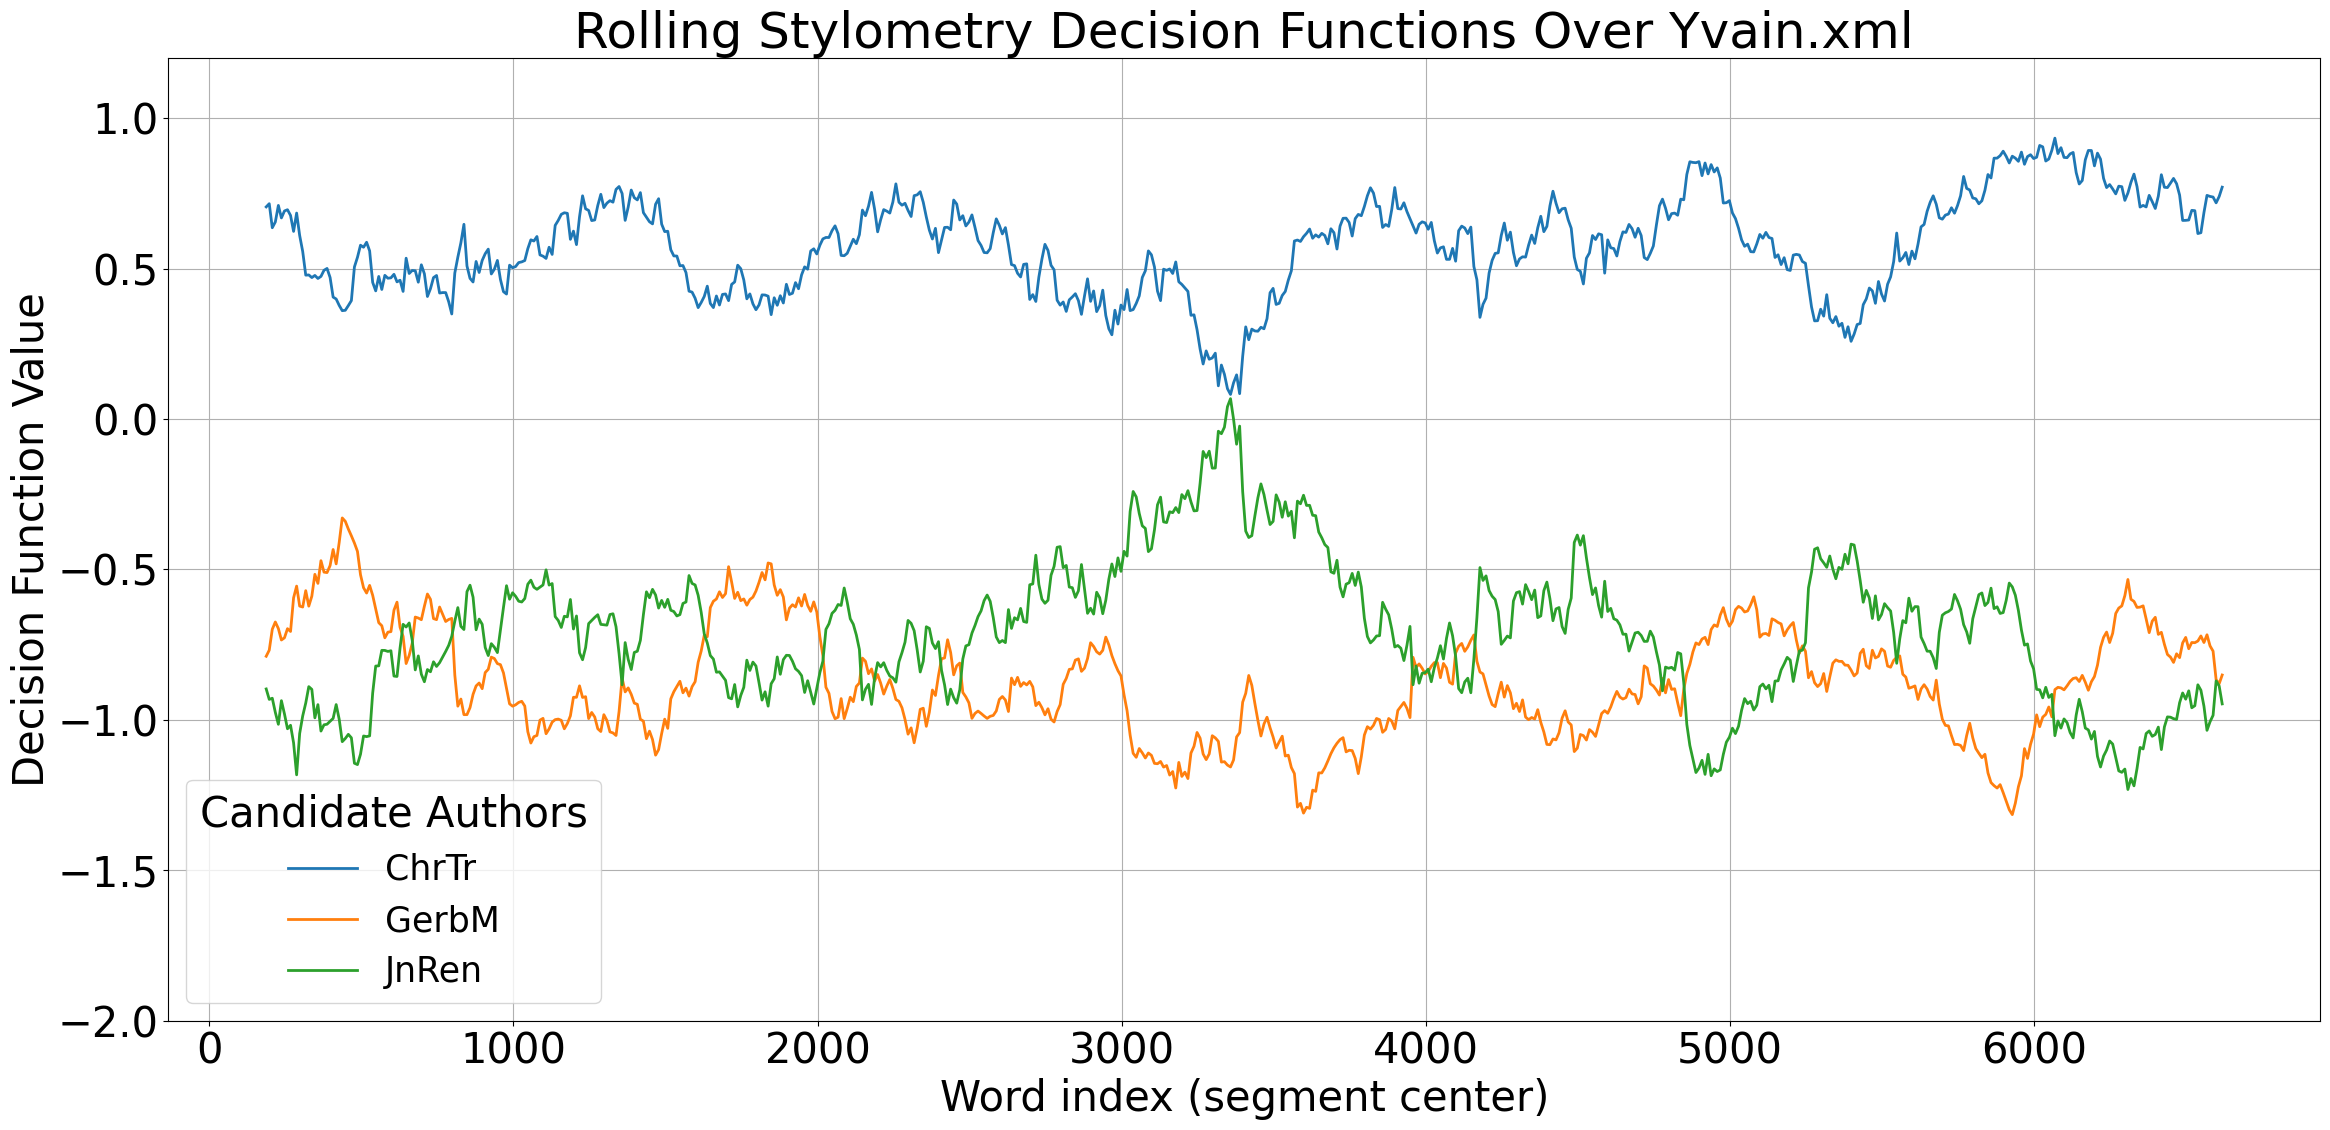

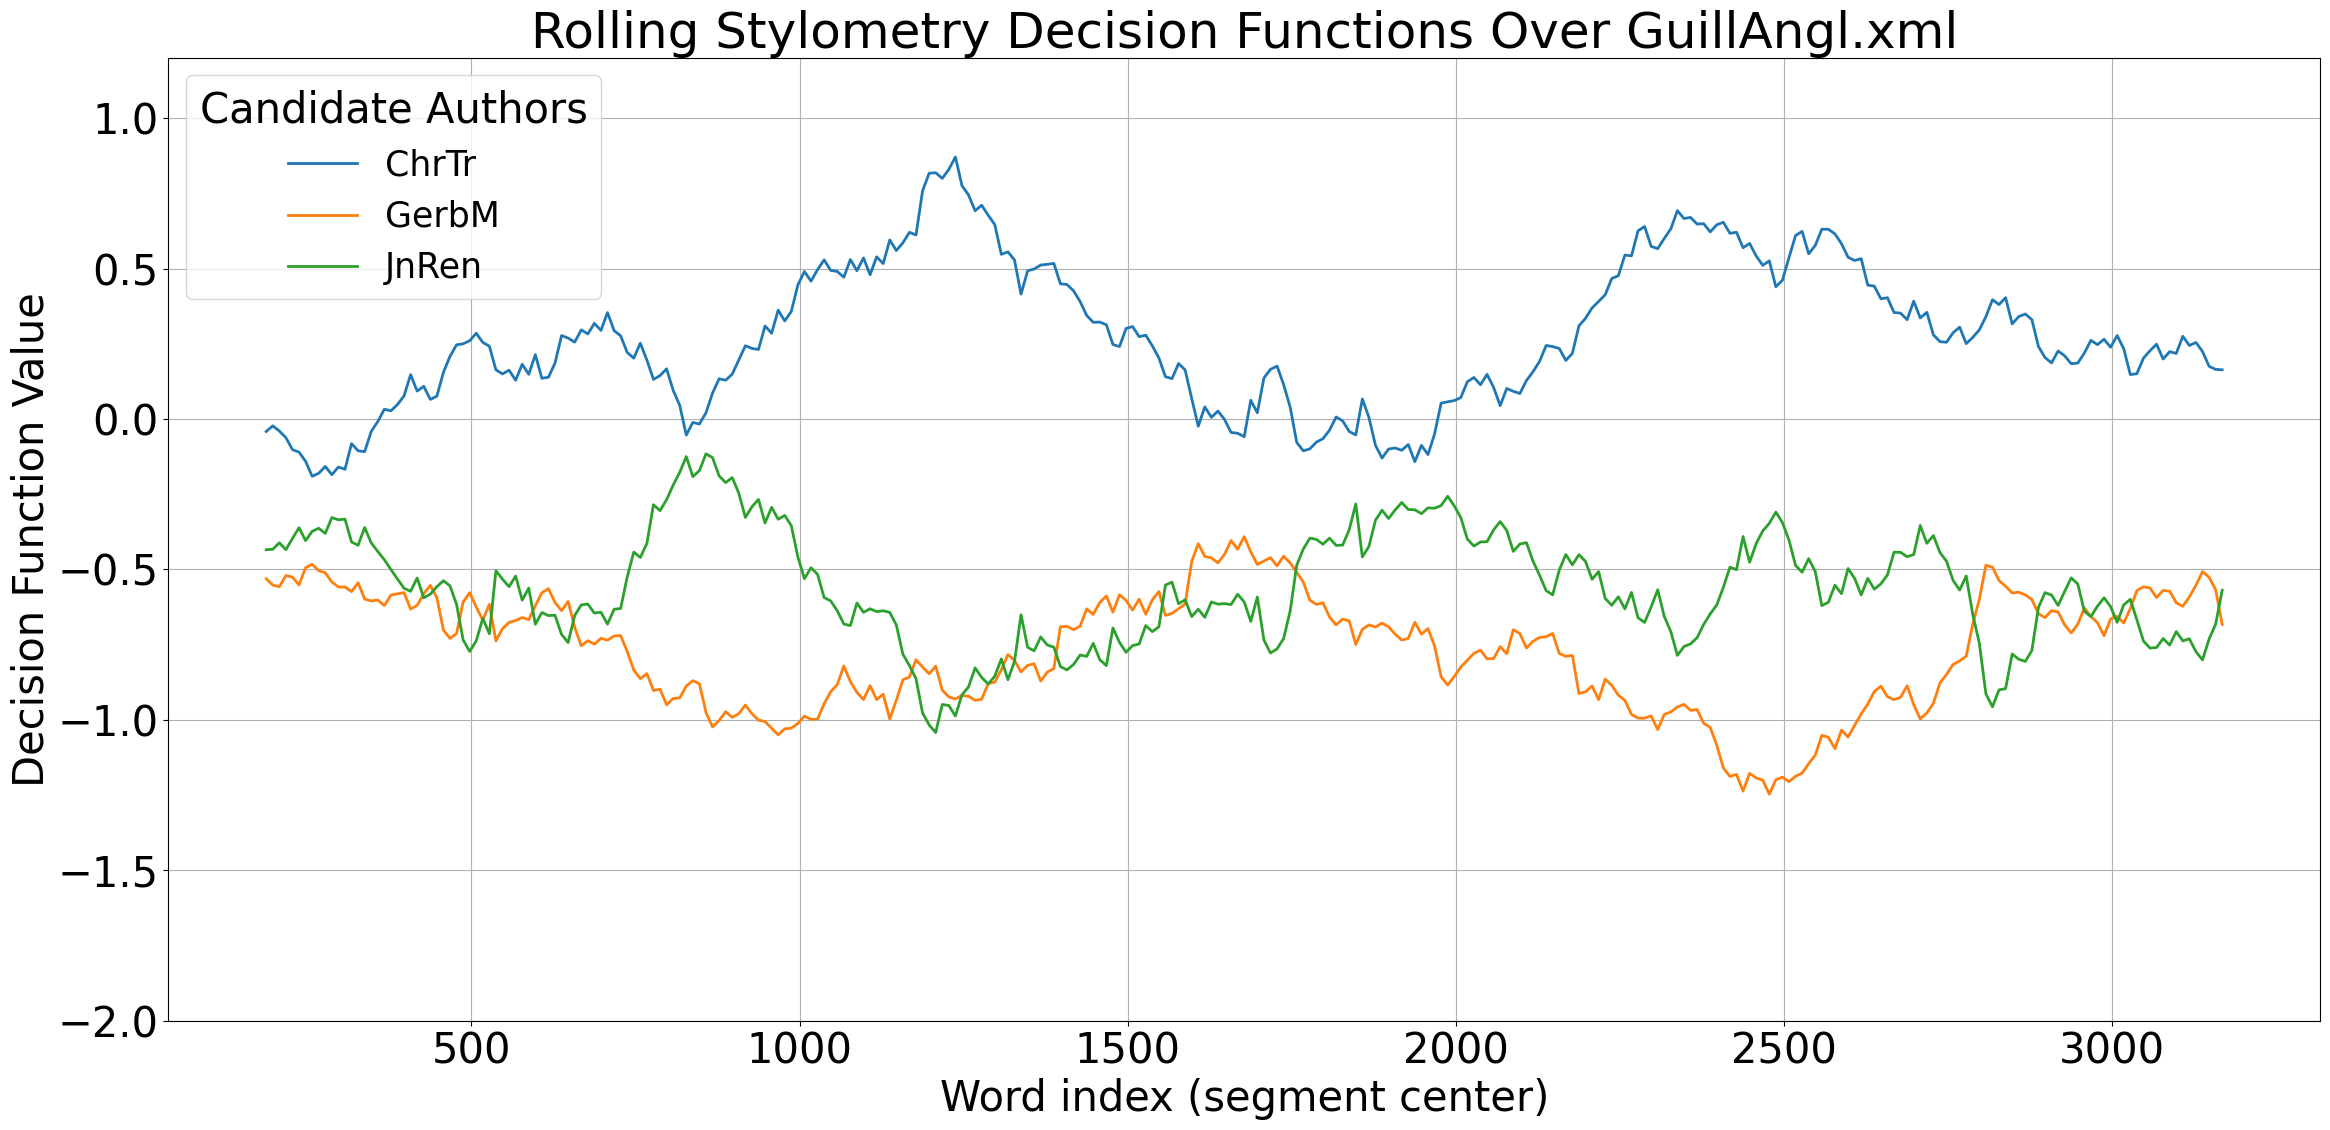

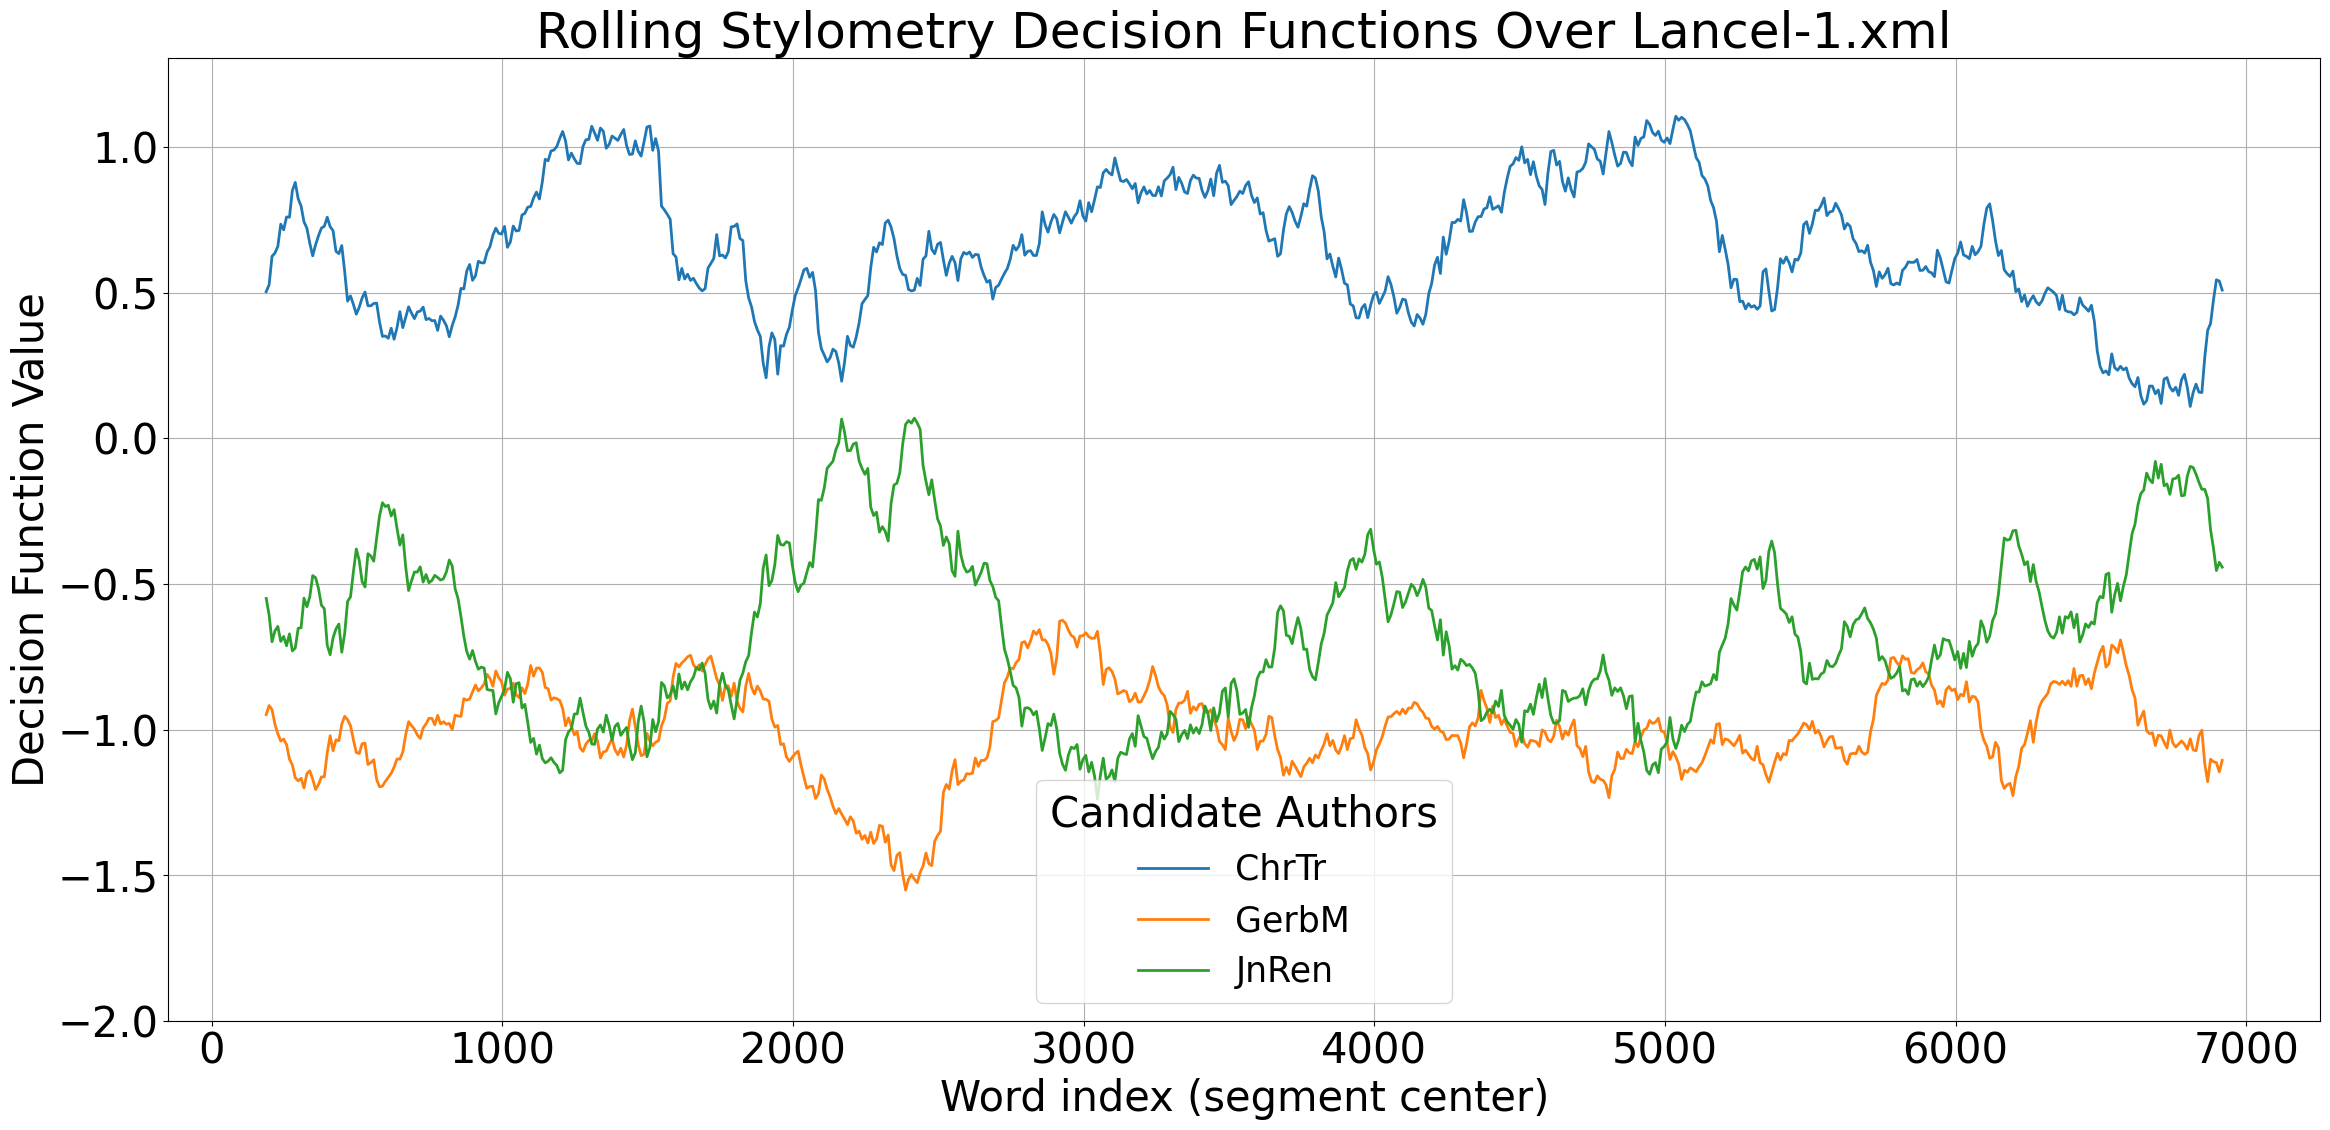

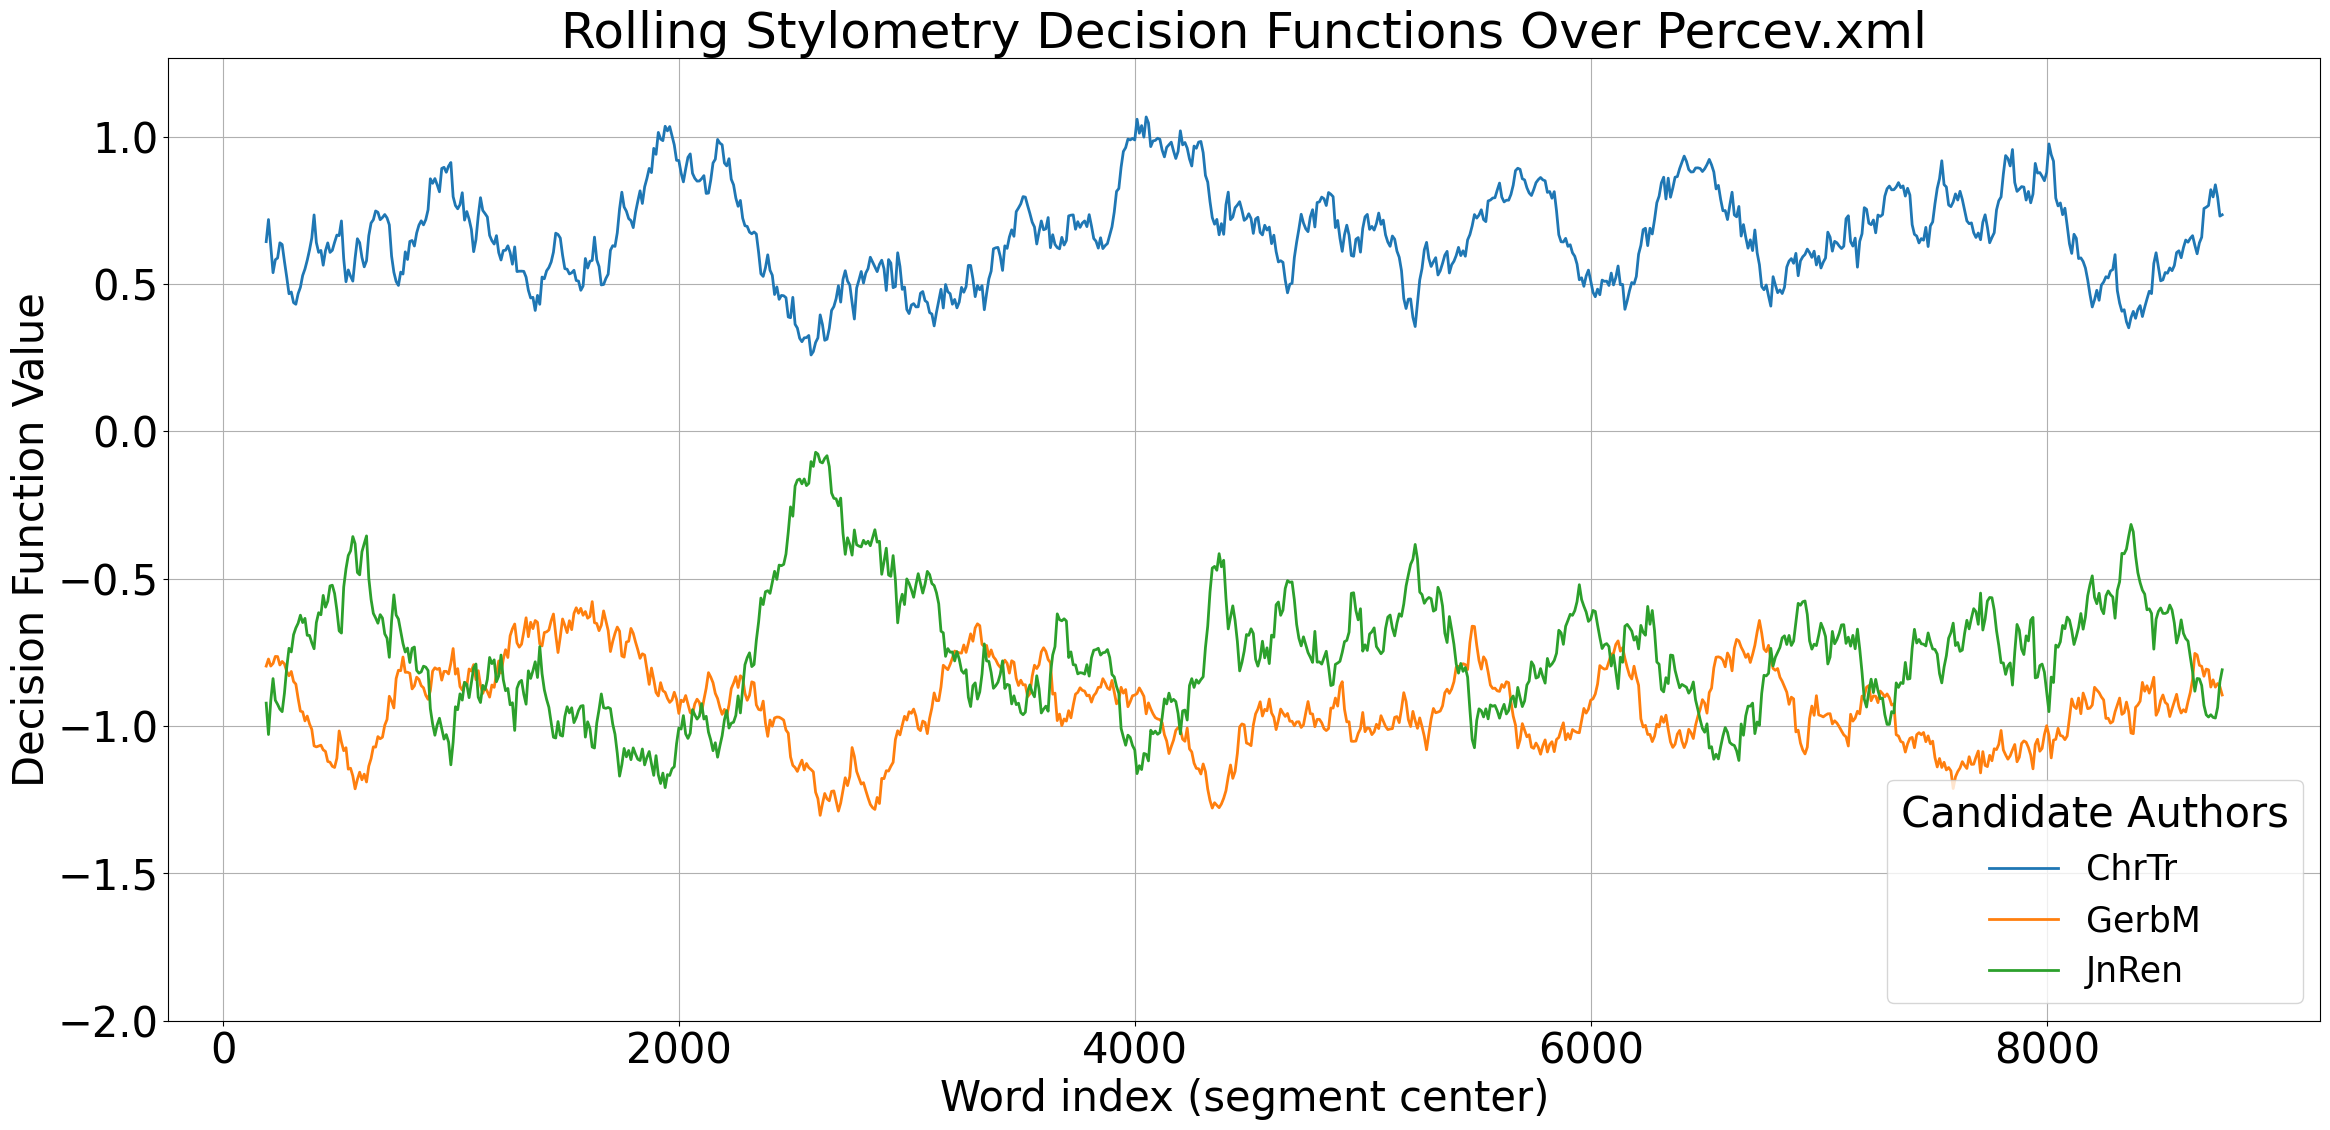

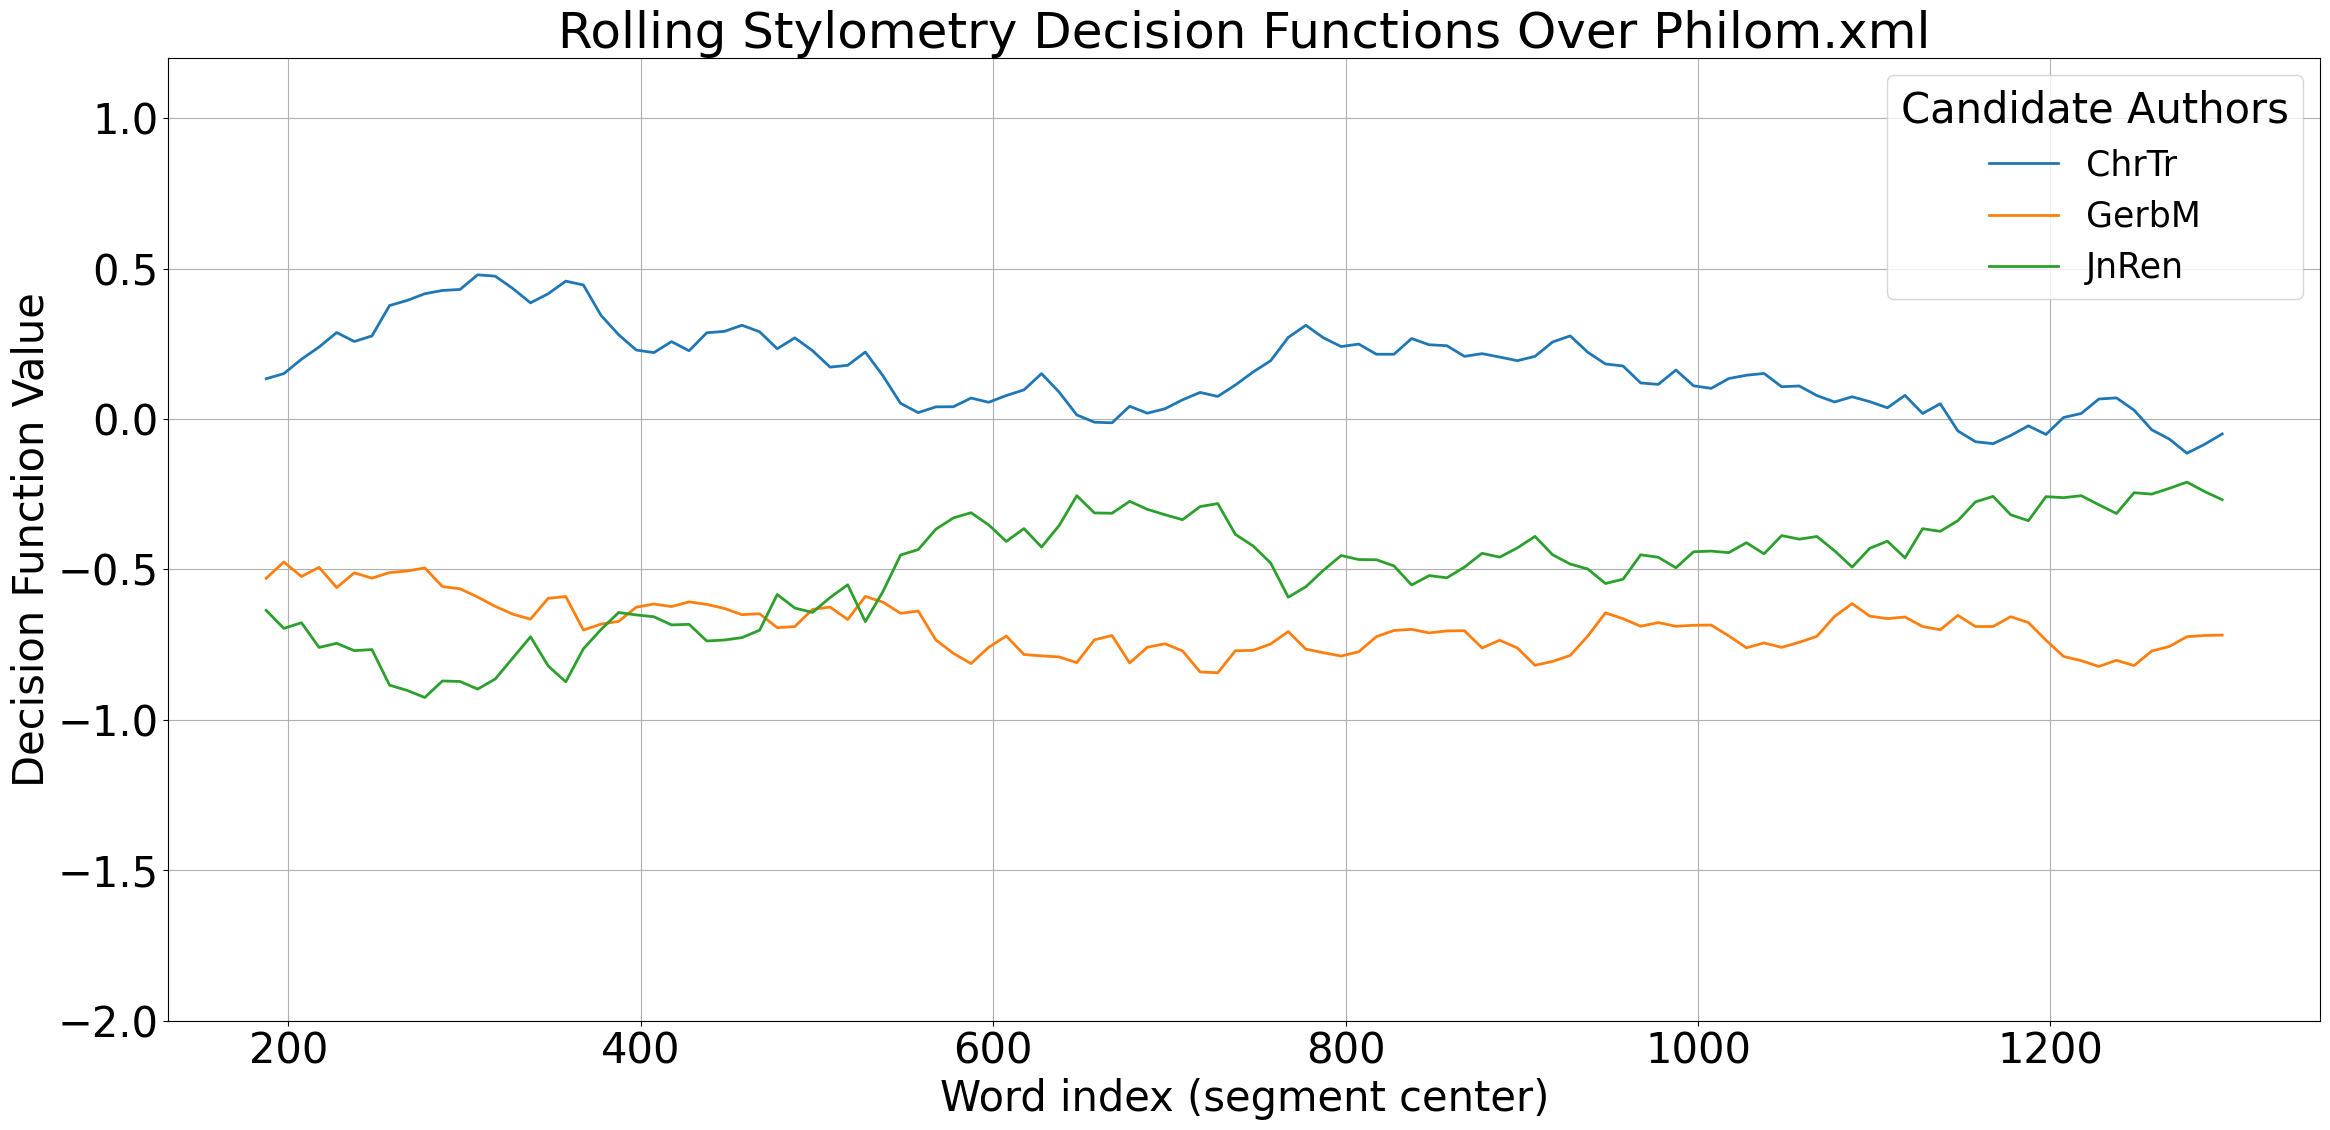

In [102]:
train_config_file = os.path.join(directory, f'best_FW_MetLine.json')
train_set, feat_lists = load_corpus_from_config(train_config_file)

feat_list_files = [os.path.join(directory, "feat_list1.json"), os.path.join(directory, "feat_list2.json")]

for (i,file) in enumerate(feat_list_files):
    with open(file, 'w') as f:
        json.dump(feat_lists[i], f, ensure_ascii=False, indent=4)


with open(train_config_file, 'r') as f:
   test_config_dict = json.load(f)


test_config_dict["paths"] = "../data/xml/nowordnoelisions/unseen/*"
test_config_dict["sampling"]["step"] = 10
test_config_dict["features"][0]["feat_list"] =  feat_list_files[0]
test_config_dict["features"][1]["feat_list"] =  feat_list_files[1]
test_config_dict["features"][0]["culling"] =  0
test_config_dict["features"][1]["culling"] =  0

test_config_file = os.path.join(directory, f'test_best_FW_MetLine.json')
with open(test_config_file, 'w') as f:
    json.dump(test_config_dict, f, ensure_ascii=False, indent=4)


test_set, feat_list = load_corpus_from_config(test_config_file, is_test=True)



results = train_svm(train=train_set,
                    test=test_set,
                    balance="downsampling",
                    class_weights=True,
                    get_coefs=True,
                    final_pred=True,
                    )

plot_rolling(results["final_predictions"], smoothing=0)